In [ ]:
!python --version

Python 3.11.12


In [ ]:
!pip install pymc
import pandas as pd
import numpy as np
import pymc as pm
import pytensor.tensor as pt # Для pt.concatenate

import matplotlib.pyplot as plt
import arviz as az

import pymc.sampling.jax as pmjax
!pip install numpyro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 kB 21.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.loc[:,['CONS', 'GDP', 'INV']] .apply(lambda x: x - x.mean())

NameError: name 'df' is not defined

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/data.xlsx')
df = df.pivot(index=['date', 'country'], columns='indicator', values='value_mom_sa').reset_index()
df.columns = ['date', 'country', 'CONS', 'GDP', 'INV']
df.sort_values(['country', 'date'], inplace=True)
df.loc[:,['CONS', 'GDP', 'INV']] = df.loc[:,['CONS', 'GDP', 'INV']] / 100
df.loc[:,['CONS', 'GDP', 'INV']] = df.loc[:,['CONS', 'GDP', 'INV']] .apply(lambda x: x - x.mean())
df

,date,country,CONS,GDP,INV
0,2001-09-01,AUS,-0.000420,0.005781,0.042522
51,2001-12-01,AUS,0.002301,0.002825,0.003944
102,2002-03-01,AUS,0.004172,0.005537,0.038218
153,2002-06-01,AUS,0.000281,0.006667,0.030395
204,2002-09-01,AUS,0.005645,-0.001930,0.027882
...,...,...,...,...,...
4385,2022-12-01,ZAF,-0.008301,-0.030752,-0.016717
4436,2023-03-01,ZAF,-0.002707,0.003901,0.010750
4487,2023-06-01,ZAF,-0.004485,0.000744,0.034350
4538,2023-09-01,ZAF,-0.003806,-0.011193,-0.037768


regions =

{
  
    "Europe": [
        "AUS", "AUT", "BEL", "BGR", "CHE", "CYP", "CZE", "DEU", "DNK",
        "ESP", "EST", "FIN", "FRA", "GBR", "GRC", "HRV", "HUN", "IRL",
        "ITA", "LTU", "LUX", "LVA", "NLD", "NOR", "POL", "PRT", "ROU",
        "RUS", "SVK", "SVN", "SWE"
    ],
    "Asia": [
        "CHN", "IDN", "IND", "ISR", "JPN", "KOR", "MYS", "PHL", "THA",
        "TWN", "TUR"
    ],
    "North America": ["CAN", "USA", "MEX"],
    "South America": ["BRA", "CHL"],
    "Oceania": ["AUS", "NZL"],
    "Africa": ["ZAF"]
}

$y_{i, t} = a_i + b^{word}_i * f^{word}_t + b^{region}_i * f^{region}_{r, t} + b^{country}_i * f^{country}_{n, t} + e_{i, t}$


*   i - переменные * число стран
*   t - период времен
*   r - число регионов
*   n - число стран
*   e - ошибка


$e_{i, t} = AR(e_{i, t})$ с лагом 3 $ + u_{i, t}$


*   $u_{i, t}$ - независимы друг от друга по $i$ и $t$
*   $e_{i, t}$ независимы друг от друга по $i$

$f_{k, t} = AR(f_{k, t})$ с лагом 3 $ + u_{i, t}$

$u_{i, t}$ - независимы друг от друга


Все переменные имеют стандратное нормальное распределние, кроме:


Параметров AR (там нормальное, с параметрами N(0, [1, 0.5, 0.25]) у соответствующих лагов)

и $u_{i, t}$, где (нормальное распределение с параметрами Normal(0,$Inverse-Gamma(3,0.0005)$) )

и $b_{i}$, где распределение HalfNormal(0, 1) (положительное только у одного из показателей, у остальных Normal (всё из-за неопределённости знака f и b))




## Варианты модели

In [ ]:
# Развитые страны (ЕВР (просто в европе) + СА + КАНАДА + АВСТР + НВ.ЗЕЛ. + ЧИЛИ)
# Развитые страны Азии (ТВН + КОРЕЯ + ЯПОНИЯ + СИНГАПУР + ТАЙЛАНД + МАЛАЙзия)
# Развивающаяся Азия (Турция + Индия + Филипины + Индонезия + Китай + всё-всё-всё что в азии и не вошло)
# Южная Африка и Бразилия + Россия

# Израиль всегда развитый

In [ ]:
# 1 вариант
# Развитые страны
# Развивающиеся страны

# И Россию сначала в одну группу и потом в другую и сравнить

In [ ]:
# 2 вариант

# Отдельно развитые страны Европы
# Развитые страны Азии
# Все остальные развивабщиеся страны

# Россию по всем 3 группам отдельно

In [ ]:
# 3 вариант

# Развитая Европа в целом (+ Чили + Австралия + НВЗ)
# Вся Азия

# Без ЮАР и Бразилии

# Россия 2 варианта так же как и в прошлый раз

In [ ]:
# 4 вариант

# Каким-то образом включить фактор Китая отдельно (возможно так же отдельно включить в модели выше)


##1 вариант модели

In [ ]:
# 1 вариант
# Развитые страны
# Развивающиеся страны

# И Россию сначала в одну группу и потом в другую и сравнить

In [ ]:
# MLT? (нужна ли вообще Мальта)

developed = ["AUS", "AUT", "BEL", "BGR", "CHE", "CYP", "CZE", "DEU", "DNK",
             "ESP", "EST", "FIN", "FRA", "GBR", "GRC", "HRV", "HUN", "IRL",
             "ITA", "LTU", "LUX", "LVA", "NLD", "NOR", "POL", "PRT", "ROU",
             "SVK", "SVN", "SWE", "ISR", "JPN", "KOR", "MYS", "TWN", "TUR",
             "CAN", "USA", "CHL", "NZL", 'SGP', 'MLT'
            ]
developing = ['RUS', "IDN", "IND", "PHL", "THA", 'MEX', "BRA", 'ZAF', 'BCHN'
             ]
regions = [developed, developing]

countries = df['country'].unique()
countries_value = {i: df[df['country'] == i][['CONS',	'GDP',	'INV']].values for i in countries}

In [ ]:
# Тест
regions['RUS' in developing]

['RUS', 'IDN', 'IND', 'PHL', 'THA', 'MEX', 'BRA', 'ZAF', 'BCHN']

In [ ]:
# 51 страна, 90 наблюдений, 3 показателя, 2 региона

model = pm.Model()

with model:
  sigma_u_f_world = pm.InverseGamma('sigma_u_f_world', alpha=3, beta=0.0005, shape=(1))
  sigma_u_f_region = pm.InverseGamma('sigma_u_f_region', alpha=3, beta=0.0005, shape=(2))
  sigma_u_f_country = pm.InverseGamma('sigma_u_f_country', alpha=3, beta=0.0005, shape=(51))
  sigma_u_err = pm.InverseGamma('sigma_u_err', alpha=3, beta=0.0005, shape=(153))

  # Для одной переменной (потребления) делаем все b >= 0, чтобы определить знак у f и остальных b
  # Возможно нужно и для одной страны только сделать, но чет не уверен, в любом случае не должны коэффициенты у разных стран сильно отличаться
  b_world_CONS = pm.HalfNormal('b_world_CONS', sigma=1, shape=(51))      # 1 показатель, 51 страна
  b_region_CONS = pm.HalfNormal('b_region_CONS', sigma=1, shape=(51))    # 1 показатель, 51 страна
  b_country_CONS = pm.HalfNormal('b_country_CONS', sigma=1, shape=(51))  # 1 показатель, 51 страна

  b_world_other = pm.Normal('b_world_other', mu=0, sigma=1, shape=(102))     # 2 показателя, 51 страна
  b_region_other = pm.Normal('b_region_other', mu=0, sigma=1, shape=(102))   # 2 показателя, 51 страна
  b_country_other = pm.Normal('b_country_other', mu=0, sigma=1, shape=(102)) # 2 показателя, 51 страна

  # Объединяем b
  b_world = pm.Deterministic('b_world', pt.concatenate([b_world_CONS, b_world_other]))          # 3 показателя, 51 страна
  b_region = pm.Deterministic('b_region', pt.concatenate([b_region_CONS, b_region_other]))      # 3 показателя, 51 страна
  b_country = pm.Deterministic('b_country', pt.concatenate([b_country_CONS, b_country_other]))  # 3 показателя, 51 страна

  const = pm.Normal('const', mu=0, sigma=1, shape=(153)) # 3 показателя, 51 страна

  err_rho = pm.Normal('err_rho', mu=0, sigma=[1, 1/2, 1/4], shape=(153, 3))
  err = pm.AR('err', sigma=sigma_u_err, rho=err_rho, constant=False, shape=(153, 90), init_dist=pm.Normal.dist(0, 1, shape=(153, 90))) # 3 показателя, 51 страна, 90 временных периодов

  f_world_rho = pm.Normal('f_world_rho', mu=0, sigma=[1, 1/2, 1/4], shape=(1, 3))
  f_region_rho = pm.Normal('f_region_rho', mu=0, sigma=[1, 1/2, 1/4], shape=(2, 3))
  f_country_rho = pm.Normal('f_country_rho', mu=0, sigma=[1, 1/2, 1/4], shape=(51, 3))

  # Про init_dist авторами тоже не написано
  f_world = pm.AR('f_world',sigma=sigma_u_f_world, rho=f_world_rho, constant=False, shape=(1, 90), init_dist=pm.Normal.dist(0, 1, shape=3))               # 1 показатель, 90 периодов
  f_region = pm.AR('f_region',sigma=sigma_u_f_region, rho=f_region_rho, constant=False, shape=(2, 90), init_dist=pm.Normal.dist(0, 1, shape=(2, 3)))      # 2 региона, 90 периодов
  f_country = pm.AR('f_country',sigma=sigma_u_f_country, rho=f_country_rho, constant=False, shape=(51, 90), init_dist=pm.Normal.dist(0, 1, shape=(51, 3))) # 51 страна, 90 периодов

  # Вопрос как задавали авторы
  sigma_y = pm.InverseGamma('sigma_y', alpha=3, beta=0.0005, shape=(153)) # 3 показателя, 51 страна

  country_id = -1
  pokazatel_id = -1

  for country in countries_value.keys():
    pokazatel_id = -1
    country_id += 1
    for y in countries_value[country].T:
      pokazatel_id += 1
      # В статье не указано какое распределение у y выбрано, скорее всего т.к. везде сумма Normal, то и здесь Normal (должно быть не принципиально)
      # Вопрос с дисперсией тот же
      id = country_id + pokazatel_id * 51
      region_id = int(country in developing)
      mu = (const[id] +                               # Число
            b_world[id] * f_world[0,:] +              # Число * array длинной 90
            b_region[id] * f_region[region_id,:] +    # Число * array длинной 90
            b_country[id] * f_country[country_id,:] + # Число * array длинной 90
            err[id,:]                                 # array длинной 90
           )
      y_obs = pm.Normal(f"y_{['CONS',	'GDP',	'INV'][pokazatel_id]}_{country}_obs", mu=mu, sigma=sigma_y[id], observed=y)

  trace = pmjax.sample_numpyro_nuts(draws=5_000, tune=10_000, chains=1)

# С богом!


Exception ignored in: <function _xla_gc_callback at 0x7b948690aca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
trace = az.from_netcdf("/content/drive/MyDrive/trace_model_1_actual.nc")

In [ ]:
trace.posterior.f_world.values[0].shape

In [ ]:
# мировой

data = trace.posterior.f_world.values[0][:,[0],:]

mean_values = data.mean(axis=0).squeeze()  # Среднее значение по первому измерению
lower_quantile = np.quantile(data, q=0.025, axis=0).squeeze()  # Нижний квантиль
upper_quantile = np.quantile(data, q=0.975, axis=0).squeeze()  # Верхний квантиль

# Готовим x-значения (предполагаем, что df['date'] уже определен)
x = df['date'].dt.strftime('%Y-%m').unique().tolist()

# Отображаем только каждую 4-ю метку на оси X
x_ticks = [x[i] if i % 4 == 0 else '' for i in range(len(x))]

# Строим график
plt.figure(figsize=(15, 8))
plt.plot(x, mean_values, label="Среднее", color="blue", linewidth=1)

# Закрашиваем доверительный интервал
plt.fill_between(x, lower_quantile, upper_quantile, color="blue", alpha=0.5, label="95% ДИ")

# Настройка осей
plt.xticks(ticks=range(len(x)), labels=x_ticks, rotation=45)  # Выводим только каждую 4-ю метку
plt.title("Среднее и 95% доверительный интервал")
plt.xlabel("Точки (x)")
plt.ylabel("Значения (y)")
plt.legend()
plt.grid(alpha=0.3)

# Отображаем график
plt.tight_layout()  # Автоматическая подгонка элементов графика
plt.show()

In [ ]:
trace.posterior.f_region.values.shape

In [ ]:
# развитые

data = trace.posterior.f_region.values[0][:,[0],:]

mean_values = data.mean(axis=0).squeeze()  # Среднее значение по первому измерению
lower_quantile = np.quantile(data, q=0.025, axis=0).squeeze()  # Нижний квантиль
upper_quantile = np.quantile(data, q=0.975, axis=0).squeeze()  # Верхний квантиль

# Готовим x-значения (предполагаем, что df['date'] уже определен)
x = df['date'].dt.strftime('%Y-%m').unique().tolist()

# Отображаем только каждую 4-ю метку на оси X
x_ticks = [x[i] if i % 4 == 0 else '' for i in range(len(x))]

# Строим график
plt.figure(figsize=(15, 8))
plt.plot(x, mean_values, label="Среднее", color="blue", linewidth=1)

# Закрашиваем доверительный интервал
plt.fill_between(x, lower_quantile, upper_quantile, color="blue", alpha=0.5, label="95% ДИ")

# Настройка осей
plt.xticks(ticks=range(len(x)), labels=x_ticks, rotation=45)  # Выводим только каждую 4-ю метку
plt.title("Среднее и 95% доверительный интервал")
plt.xlabel("Точки (x)")
plt.ylabel("Значения (y)")
plt.legend()
plt.grid(alpha=0.3)

# Отображаем график
plt.tight_layout()  # Автоматическая подгонка элементов графика
plt.show()

In [ ]:
# неразвитые

data = trace.posterior.f_region.values[0][:,[1],:]

mean_values = data.mean(axis=0).squeeze()  # Среднее значение по первому измерению
lower_quantile = np.quantile(data, q=0.025, axis=0).squeeze()  # Нижний квантиль
upper_quantile = np.quantile(data, q=0.975, axis=0).squeeze()  # Верхний квантиль

# Готовим x-значения (предполагаем, что df['date'] уже определен)
x = df['date'].dt.strftime('%Y-%m').unique().tolist()

# Отображаем только каждую 4-ю метку на оси X
x_ticks = [x[i] if i % 4 == 0 else '' for i in range(len(x))]

# Строим график
plt.figure(figsize=(15, 8))
plt.plot(x, mean_values, label="Среднее", color="blue", linewidth=1)

# Закрашиваем доверительный интервал
plt.fill_between(x, lower_quantile, upper_quantile, color="blue", alpha=0.5, label="95% ДИ")

# Настройка осей
plt.xticks(ticks=range(len(x)), labels=x_ticks, rotation=45)  # Выводим только каждую 4-ю метку
plt.title("Среднее и 95% доверительный интервал")
plt.xlabel("Точки (x)")
plt.ylabel("Значения (y)")
plt.legend()
plt.grid(alpha=0.3)

# Отображаем график
plt.tight_layout()  # Автоматическая подгонка элементов графика
plt.show()

In [ ]:
trace.posterior

In [ ]:
list(countries_value.keys())

In [ ]:
trace.posterior.f_country.values.shape

In [ ]:
# [na, eu, me, asia]
for i in range(51):
  data = trace.posterior.f_country.values[0][:,[i],:]

  mean_values = data.mean(axis=0).squeeze()  # Среднее значение по первому измерению
  lower_quantile = np.quantile(data, q=0.025, axis=0).squeeze()  # Нижний квантиль
  upper_quantile = np.quantile(data, q=0.975, axis=0).squeeze()  # Верхний квантиль

  # Готовим x-значения (предполагаем, что df['date'] уже определен)
  x = df['date'].dt.strftime('%Y-%m').unique().tolist()

  # Отображаем только каждую 4-ю метку на оси X
  x_ticks = [x[i] if i % 4 == 0 else '' for i in range(len(x))]

  # Строим график
  plt.figure(figsize=(15, 8))
  plt.plot(x, mean_values, label="Среднее", color="blue", linewidth=1)

  # Закрашиваем доверительный интервал
  plt.fill_between(x, lower_quantile, upper_quantile, color="blue", alpha=0.5, label="95% ДИ")

  # Настройка осей
  plt.xticks(ticks=range(len(x)), labels=x_ticks, rotation=45)  # Выводим только каждую 4-ю метку
  plt.title(list(countries_value.keys())[i])
  plt.xlabel("Точки (x)")
  plt.ylabel("Значения (y)")
  plt.legend()
  plt.grid(alpha=0.3)

  # Отображаем график
  plt.tight_layout()  # Автоматическая подгонка элементов графика
  plt.show()

## 1 вариант модели 2 вариант




In [ ]:
# Развитые страны (не все, но самые крупные)
# Развивающиеся страны (видимо тоже не все?)

# И добавляем переменную alpha, которая отвечает за принадлежность России к группе развитых и развивающихся

In [ ]:
df['country'].unique()

array(['AUS', 'AUT', 'BCHN', 'BEL', 'BGR', 'BRA', 'CAN', 'CHE', 'CHL',
       'CYP', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR',
       'GRC', 'HRV', 'HUN', 'IDN', 'IND', 'IRL', 'ISR', 'ITA', 'JPN',
       'KOR', 'LTU', 'LUX', 'LVA', 'MEX', 'MLT', 'MYS', 'NLD', 'NOR',
       'NZL', 'PHL', 'POL', 'PRT', 'ROU', 'RUS', 'SGP', 'SVK', 'SVN',
       'SWE', 'THA', 'TUR', 'TWN', 'USA', 'ZAF'], dtype=object)

In [ ]:
developed = [

    "USA", "JPN", "TWN", "KOR", "CAN", "CHL", "AUS",
    "DEU", "GBR", "FRA", "ITA", "ESP", "NLD", "CHE", "POL",
    #"BEL", "SWE", "IRL", "AUT", "NOR", "DNK", "ROU", "CZE"
            ]

developing = [
    "BCHN",
    "RUS",
    "IND",
    "IDN", "PHL", "THA", "MYS", "SGP",
    "BRA",
    "TUR",
    # "ZAF",
]


# developed = ["AUS", "AUT", "BEL", "BGR", "CHE", "CYP", "CZE", "DEU", "DNK",
#              "ESP", "EST", "FIN", "FRA", "GBR", "GRC", "HRV", "HUN", "IRL",
#              "ITA", "LTU", "LUX", "LVA", "NLD", "NOR", "POL", "PRT", "ROU",
#              "SVK", "SVN", "SWE", "ISR", "JPN", "KOR", "MYS", "TWN", "TUR",
#              "CAN", "USA", "CHL", "NZL", 'SGP', 'MLT'
#             ]
# developing = ['RUS', "IDN", "IND", "PHL", "THA", 'MEX', "BRA", 'ZAF', 'BCHN'
#              ]

regions = [developed, developing]

countries = developed + developing
countries_value = {i: df[df['country'] == i][['GDP','CONS','INV']].values for i in countries}

$y_{i, t} = a_i + b^{word}_i * f^{word}_t + b^{region}_i * f^{region}_{r, t} + b^{country}_i * f^{country}_{n, t} + e_{i, t}$ - для всех стран кроме России

$y_{i, t} = a_i +  b^{word}_i * f^{word}_t + \frac{tanh(\alpha_i) + 1}{2} * b^{region1}_i * f^{region1}_{r, t} + \frac{1 - tanh(\alpha_i)}{2} * b^{region2}_i * f^{region2}_{r, t}+ b^{country}_i * f^{country}_{n, t} + e_{i, t}$ - для России

$\alpha_i = AR(\alpha_i)$ с лагом 3 $ + u_{i, t}$

*   i - переменные * число стран
*   t - период времен
*   r - число регионов
*   n - число стран
*   e - ошибка


$e_{i, t} = AR(e_{i, t})$ с лагом 3 $ + u_{i, t}$


*   $u_{i, t}$ - независимы друг от друга по $i$ и $t$
*   $e_{i, t}$ независимы друг от друга по $i$

$f_{k, t} = AR(f_{k, t})$ с лагом 3 $ + u_{i, t}$

$u_{i, t}$ - независимы друг от друга


Все переменные имеют стандратное нормальное распределние, кроме:


Параметров AR (там нормальное, с параметрами N(0, [1, 0.5, 0.25]) у соответствующих лагов)

и $u_{i, t}$, где (нормальное распределение с параметрами Normal(0,$Inverse-Gamma(3,0.0005)$) )

и $b_{i}$, где распределение HalfNormal(0, 1) (положительное только у одного из показателей, у остальных Normal (всё из-за неопределённости знака f и b))




In [ ]:
len(countries)

25

In [ ]:
# 25 стран, 90 наблюдений, 3 показателя, 2 региона

model = pm.Model()

with model:
  sigma_u_f_world = pm.InverseGamma('sigma_u_f_world', alpha=3, beta=0.0005, shape=(1))
  sigma_u_f_region = pm.InverseGamma('sigma_u_f_region', alpha=3, beta=0.0005, shape=(2))
  sigma_u_f_country = pm.InverseGamma('sigma_u_f_country', alpha=3, beta=0.0005, shape=(25))
  sigma_u_err = pm.InverseGamma('sigma_u_err', alpha=3, beta=0.0005, shape=(75))

  # Для одной переменной (потребления) делаем все b >= 0, чтобы определить знак у f и остальных b
  # Возможно нужно и для одной страны только сделать, но чет не уверен, в любом случае не должны коэффициенты у разных стран сильно отличаться
  b_world_CONS = pm.HalfNormal('b_world_CONS', sigma=1, shape=(25))      # 1 показатель, 25 стран
  b_region_CONS = pm.HalfNormal('b_region_CONS', sigma=1, shape=(25))    # 1 показатель, 25 стран
  b_country_CONS = pm.HalfNormal('b_country_CONS', sigma=1, shape=(25))  # 1 показатель, 25 стран

  b_world_other = pm.Normal('b_world_other', mu=0, sigma=1, shape=(50))      # 2 показателя, 25 стран
  b_region_other = pm.Normal('b_region_other', mu=0, sigma=1, shape=(50))    # 2 показателя, 25 стран
  b_country_other = pm.Normal('b_country_other', mu=0, sigma=1, shape=(50))  # 2 показателя, 25 стран

  # Объединяем b
  b_world = pm.Deterministic('b_world', pt.concatenate([b_world_CONS, b_world_other]))          # 3 показателя, 25 стран
  b_region = pm.Deterministic('b_region', pt.concatenate([b_region_CONS, b_region_other]))      # 3 показателя, 25 стран
  b_country = pm.Deterministic('b_country', pt.concatenate([b_country_CONS, b_country_other]))  # 3 показателя, 25 стран

  const = pm.Normal('const', mu=0, sigma=1, shape=(75))  # 3 показателя, 25 страна

  err_rho = pm.Normal('err_rho', mu=0, sigma=[1, 1/2, 1/4], shape=(75, 3))
  err = pm.AR('err', sigma=sigma_u_err, rho=err_rho, constant=False, shape=(75, 90), init_dist=pm.Normal.dist(0, 1, shape=(75, 90))) # 3 показателя, 25 стран, 90 временных периодов

  f_world_rho = pm.Normal('f_world_rho', mu=0, sigma=[1, 1/2, 1/4], shape=(1, 3))
  f_region_rho = pm.Normal('f_region_rho', mu=0, sigma=[1, 1/2, 1/4], shape=(2, 3))
  f_country_rho = pm.Normal('f_country_rho', mu=0, sigma=[1, 1/2, 1/4], shape=(25, 3))

  # Про init_dist авторами тоже не написано
  f_world = pm.AR('f_world',sigma=sigma_u_f_world, rho=f_world_rho, constant=False, shape=(1, 90), init_dist=pm.Normal.dist(0, 1, shape=3))                # 1 показатель, 90 периодов
  f_region = pm.AR('f_region',sigma=sigma_u_f_region, rho=f_region_rho, constant=False, shape=(2, 90), init_dist=pm.Normal.dist(0, 1, shape=(2, 3)))       # 2 региона, 90 периодов
  f_country = pm.AR('f_country',sigma=sigma_u_f_country, rho=f_country_rho, constant=False, shape=(25, 90), init_dist=pm.Normal.dist(0, 1, shape=(25, 3))) # 25 страна, 90 периодов

  sigma_y = pm.InverseGamma('sigma_y', alpha=3, beta=0.0005, shape=(75)) # 3 показателя, 25 стран

  alpha_sigma = pm.InverseGamma('alpha_sigma', alpha=1, beta=0.2, shape=(1)) # Более длинные хвосты,
  alpha_rho = pm.Normal('alpha_rho', mu=0, sigma=[1, 1/2, 1/4], shape=(1, 3))
  alpha = pm.AR('alpha', sigma=alpha_sigma, rho=alpha_rho, constant=False, shape=(1, 90), init_dist=pm.Normal.dist(0, 2, shape=3))
  alpha_tanh = pm.Deterministic('alpha_tanh', pt.tanh(alpha))

  country_id = -1
  pokazatel_id = -1

  for country in countries_value.keys():
    pokazatel_id = -1
    country_id += 1
    for y in countries_value[country].T:
      pokazatel_id += 1
      # В статье не указано какое распределение у y выбрано, скорее всего т.к. везде сумма Normal, то и здесь Normal (должно быть не принципиально)
      # Вопрос с дисперсией тот же
      id = country_id + pokazatel_id * 25
      region_id = int(country in developing)
      if country == 'RUS':
        mu = (const[id] +                                                                                     # Число
              b_world[id] * f_world[0,:] +                                                                    # Число * array длинной 90
              (1 + alpha_tanh[0,:]) / 2 * b_region[id] * f_region[region_id,:] +                              # array длинной 90 * Число * array длинной 90
              (1 - alpha_tanh[0,:]) / 2 * b_region[id] * f_region[int(country not in developing),:] +         # array длинной 90 * Число * array длинной 90
              b_country[id] * f_country[country_id,:] +                                                       # Число * array длинной 90
              err[id,:]                                                                                       # array длинной 90
            )
      else:
        mu = (const[id] +                               # Число
              b_world[id] * f_world[0,:] +              # Число * array длинной 90
              b_region[id] * f_region[region_id,:] +    # Число * array длинной 90
              b_country[id] * f_country[country_id,:] + # Число * array длинной 90
              err[id,:]                                 # array длинной 90
            )
      y_obs = pm.Normal(f"y_{['CONS',	'GDP',	'INV'][pokazatel_id]}_{country}_obs", mu=mu, sigma=sigma_y[id], observed=y)

  trace = pmjax.sample_numpyro_nuts(draws=3_000, tune=5_000, chains=1)

# С богом!


warmup:  39%|███▉      | 3136/8000 [1:59:43<3:24:57,  2.53s/it, 1023 steps of size 3.62e-04. acc. prob=0.79]

In [ ]:
mu = (const[id] +                               # Число
              b_world[id] * f_world[0,:] +              # Число * array длинной 90
              b_region[id] * f_region[region_id,:] +    # Число * array длинной 90
              b_country[id] * f_country[country_id,:] + # Число * array длинной 90
              err[id,:]                                 # array длинной 90
            )

In [ ]:
trace = az.from_netcdf("/content/drive/MyDrive/trace6.nc")

In [ ]:
trace.posterior.f_region.values[0]

array([[[-0.04396819,  0.00679555,  0.00200935, ...,  0.0091007 ,
          0.00798859,  0.00556235],
        [ 0.00887593,  0.02105351, -0.00339862, ...,  0.00399438,
          0.0040716 ,  0.00730343]],

       [[-0.04408978,  0.0066529 ,  0.00196827, ...,  0.00922872,
          0.00797397,  0.00558838],
        [ 0.00822986,  0.02140515, -0.00286236, ...,  0.00405983,
          0.00420528,  0.00699769]],

       [[-0.04417482,  0.00679616,  0.00194009, ...,  0.00920234,
          0.00788148,  0.00555074],
        [ 0.00734631,  0.02153202, -0.00282309, ...,  0.00386952,
          0.00407906,  0.00702872]],

       ...,

       [[-0.0152762 ,  0.01071357,  0.0074061 , ...,  0.00922584,
          0.0065258 ,  0.00451768],
        [-0.01995242,  0.05041479,  0.01595724, ..., -0.00236819,
          0.00415943,  0.00176967]],

       [[-0.01548123,  0.01069418,  0.00735487, ...,  0.00919833,
          0.00647318,  0.00446675],
        [-0.02062611,  0.05030209,  0.01624928, ..., -0.00228

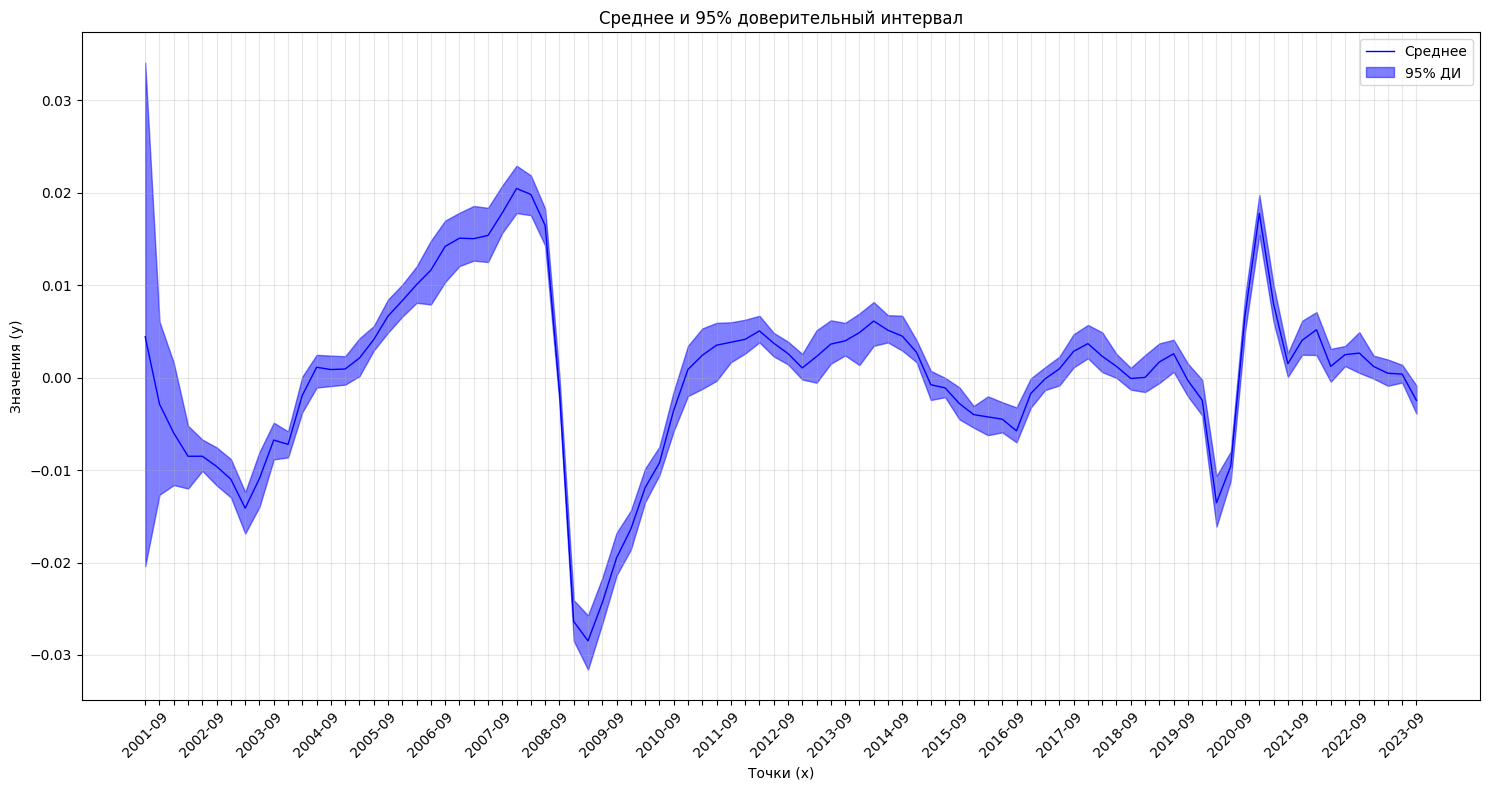

In [ ]:
# мировой

data = trace.posterior.f_world.values[1][:,[0],:]

mean_values = data.mean(axis=0).squeeze()  # Среднее значение по первому измерению
lower_quantile = np.quantile(data, q=0.025, axis=0).squeeze()  # Нижний квантиль
upper_quantile = np.quantile(data, q=0.975, axis=0).squeeze()  # Верхний квантиль

# Готовим x-значения (предполагаем, что df['date'] уже определен)
x = df['date'].dt.strftime('%Y-%m').unique().tolist()

# Отображаем только каждую 4-ю метку на оси X
x_ticks = [x[i] if i % 4 == 0 else '' for i in range(len(x))]

# Строим график
plt.figure(figsize=(15, 8))
plt.plot(x, mean_values, label="Среднее", color="blue", linewidth=1)

# Закрашиваем доверительный интервал
plt.fill_between(x, lower_quantile, upper_quantile, color="blue", alpha=0.5, label="95% ДИ")

# Настройка осей
plt.xticks(ticks=range(len(x)), labels=x_ticks, rotation=45)  # Выводим только каждую 4-ю метку
plt.title("Среднее и 95% доверительный интервал")
plt.xlabel("Точки (x)")
plt.ylabel("Значения (y)")
plt.legend()
plt.grid(alpha=0.3)

# Отображаем график
plt.tight_layout()  # Автоматическая подгонка элементов графика
plt.show()

In [ ]:
# мировой

data = trace.posterior.f_world.values[1][:,[0],:]

mean_values = data.mean(axis=0).squeeze()  # Среднее значение по первому измерению
lower_quantile = np.quantile(data, q=0.025, axis=0).squeeze()  # Нижний квантиль
upper_quantile = np.quantile(data, q=0.975, axis=0).squeeze()  # Верхний квантиль

# Готовим x-значения (предполагаем, что df['date'] уже определен)
x = df['date'].dt.strftime('%Y-%m').unique().tolist()

# Отображаем только каждую 4-ю метку на оси X
x_ticks = [x[i] if i % 4 == 0 else '' for i in range(len(x))]

# Строим график
plt.figure(figsize=(15, 8))
plt.plot(x, mean_values, label="Среднее", color="blue", linewidth=1)

# Закрашиваем доверительный интервал
plt.fill_between(x, lower_quantile, upper_quantile, color="blue", alpha=0.5, label="95% ДИ")

# Настройка осей
plt.xticks(ticks=range(len(x)), labels=x_ticks, rotation=45)  # Выводим только каждую 4-ю метку
plt.title("Среднее и 95% доверительный интервал")
plt.xlabel("Точки (x)")
plt.ylabel("Значения (y)")
plt.legend()
plt.grid(alpha=0.3)

# Отображаем график
plt.tight_layout()  # Автоматическая подгонка элементов графика
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1

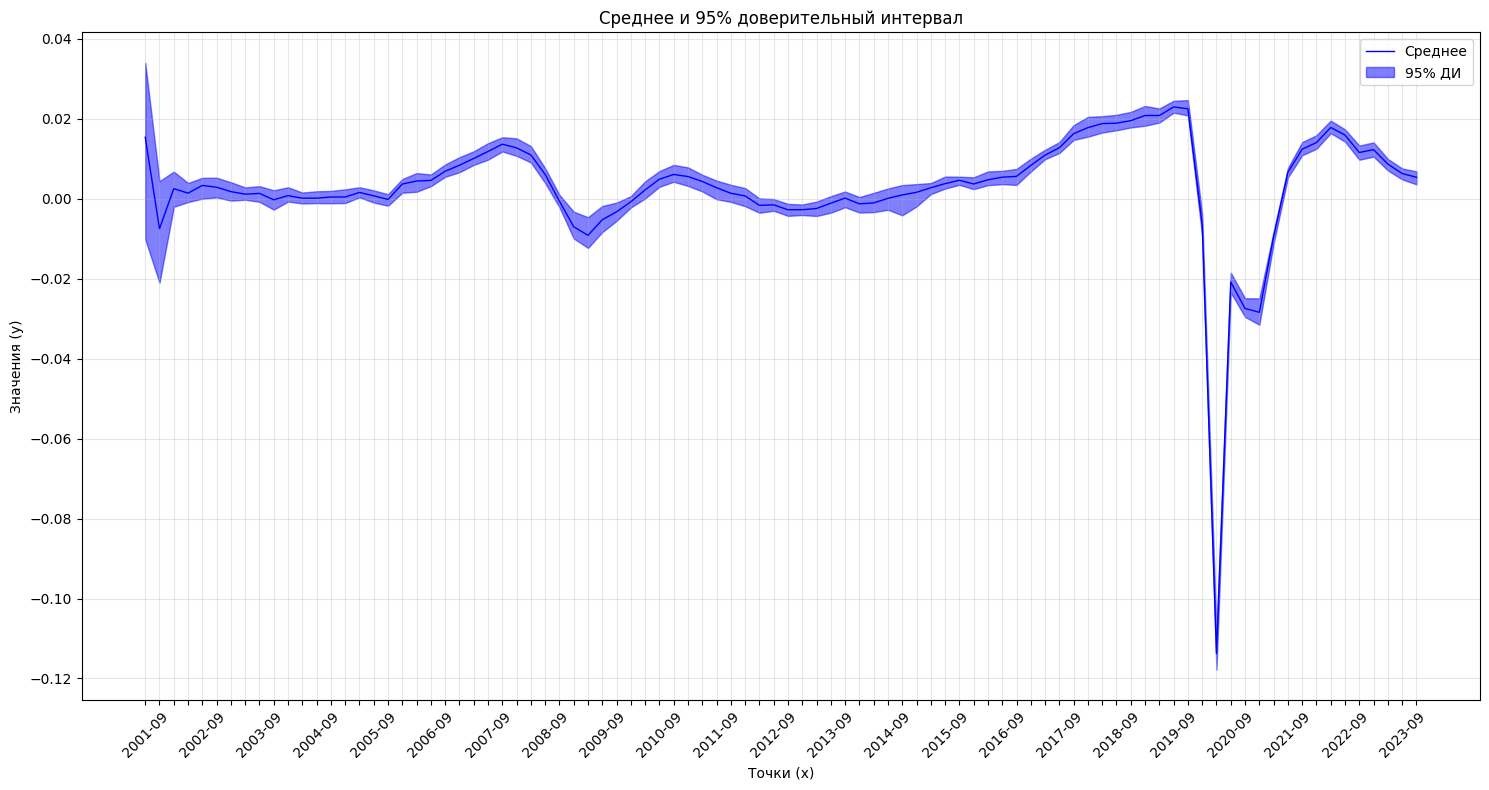

In [ ]:
# Развитые

data = trace.posterior.f_region.values[2][:,[0],:]

mean_values = data.mean(axis=0).squeeze()  # Среднее значение по первому измерению
lower_quantile = np.quantile(data, q=0.025, axis=0).squeeze()  # Нижний квантиль
upper_quantile = np.quantile(data, q=0.975, axis=0).squeeze()  # Верхний квантиль

# Готовим x-значения (предполагаем, что df['date'] уже определен)
x = df['date'].dt.strftime('%Y-%m').unique().tolist()

# Отображаем только каждую 4-ю метку на оси X
x_ticks = [x[i] if i % 4 == 0 else '' for i in range(len(x))]

# Строим график
plt.figure(figsize=(15, 8))
plt.plot(x, mean_values, label="Среднее", color="blue", linewidth=1)

# Закрашиваем доверительный интервал
plt.fill_between(x, lower_quantile, upper_quantile, color="blue", alpha=0.5, label="95% ДИ")

# Настройка осей
plt.xticks(ticks=range(len(x)), labels=x_ticks, rotation=45)  # Выводим только каждую 4-ю метку
plt.title("Среднее и 95% доверительный интервал")
plt.xlabel("Точки (x)")
plt.ylabel("Значения (y)")
plt.legend()
plt.grid(alpha=0.3)

# Отображаем график
plt.tight_layout()  # Автоматическая подгонка элементов графика
plt.show()

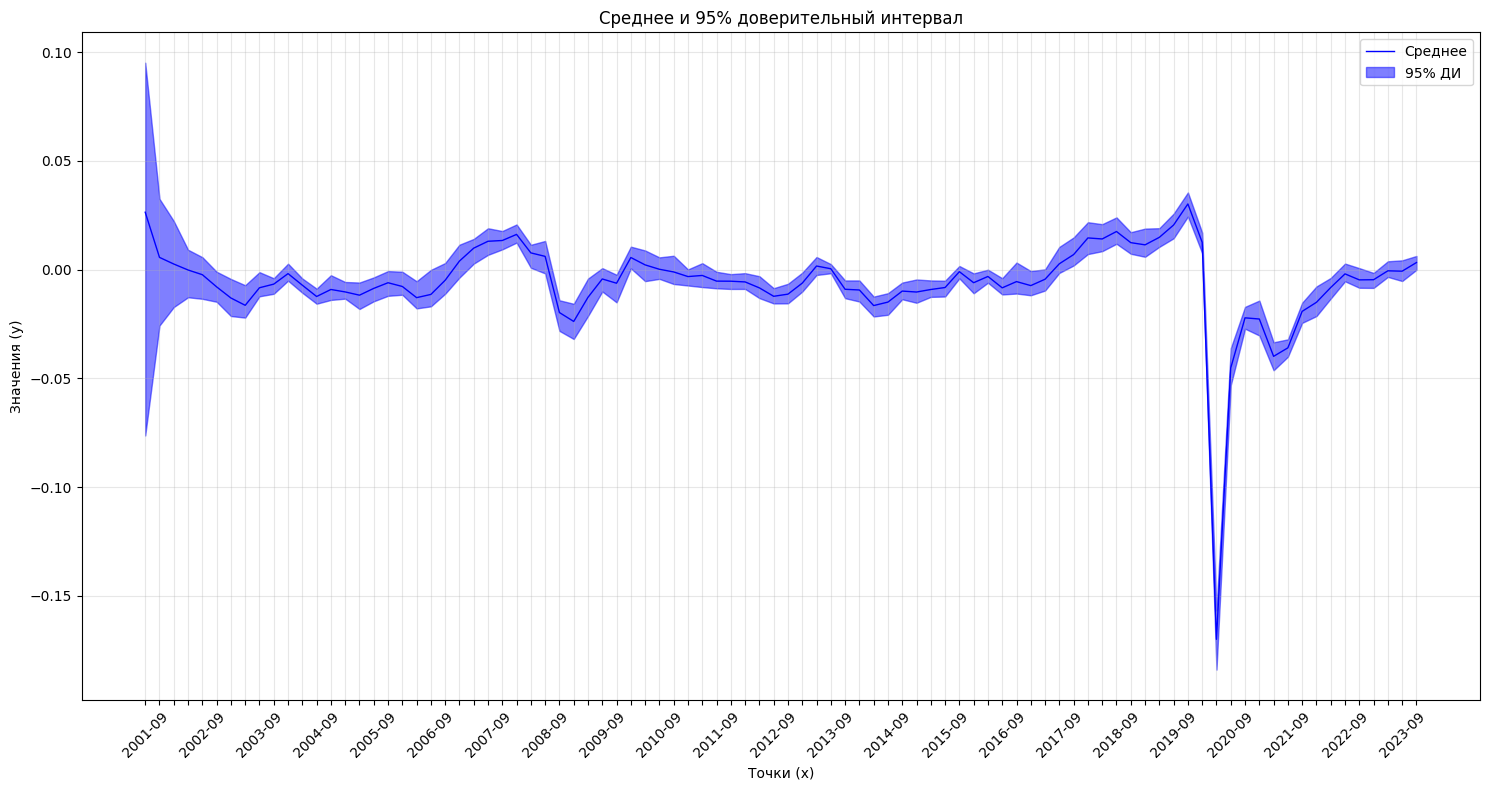

In [ ]:
# развивающиееся

data = trace.posterior.f_region.values[2][:,[1],:]

mean_values = data.mean(axis=0).squeeze()  # Среднее значение по первому измерению
lower_quantile = np.quantile(data, q=0.025, axis=0).squeeze()  # Нижний квантиль
upper_quantile = np.quantile(data, q=0.975, axis=0).squeeze()  # Верхний квантиль

# Готовим x-значения (предполагаем, что df['date'] уже определен)
x = df['date'].dt.strftime('%Y-%m').unique().tolist()

# Отображаем только каждую 4-ю метку на оси X
x_ticks = [x[i] if i % 4 == 0 else '' for i in range(len(x))]

# Строим график
plt.figure(figsize=(15, 8))
plt.plot(x, mean_values, label="Среднее", color="blue", linewidth=1)

# Закрашиваем доверительный интервал
plt.fill_between(x, lower_quantile, upper_quantile, color="blue", alpha=0.5, label="95% ДИ")

# Настройка осей
plt.xticks(ticks=range(len(x)), labels=x_ticks, rotation=45)  # Выводим только каждую 4-ю метку
plt.title("Среднее и 95% доверительный интервал")
plt.xlabel("Точки (x)")
plt.ylabel("Значения (y)")
plt.legend()
plt.grid(alpha=0.3)

# Отображаем график
plt.tight_layout()  # Автоматическая подгонка элементов графика
plt.show()

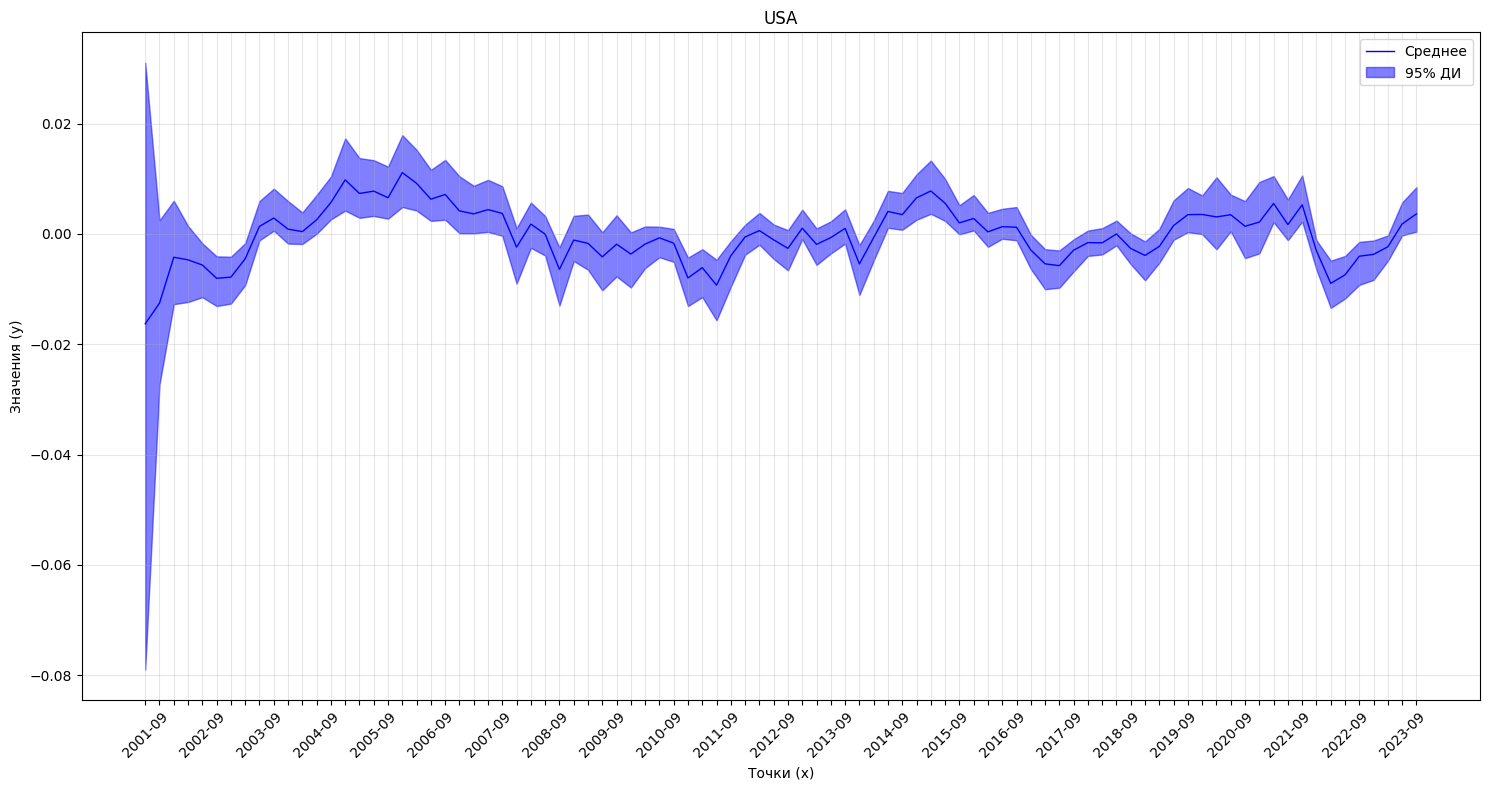

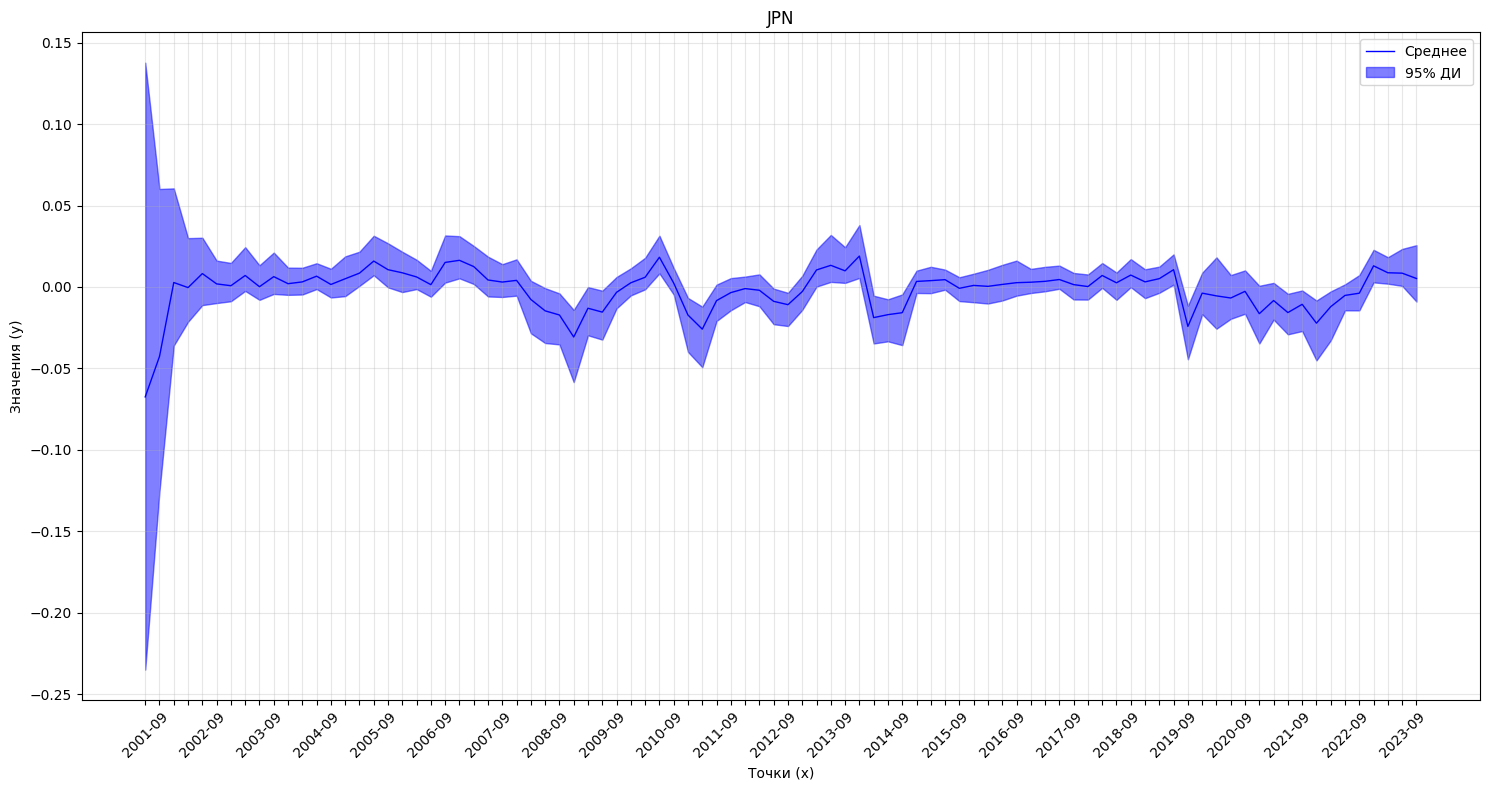

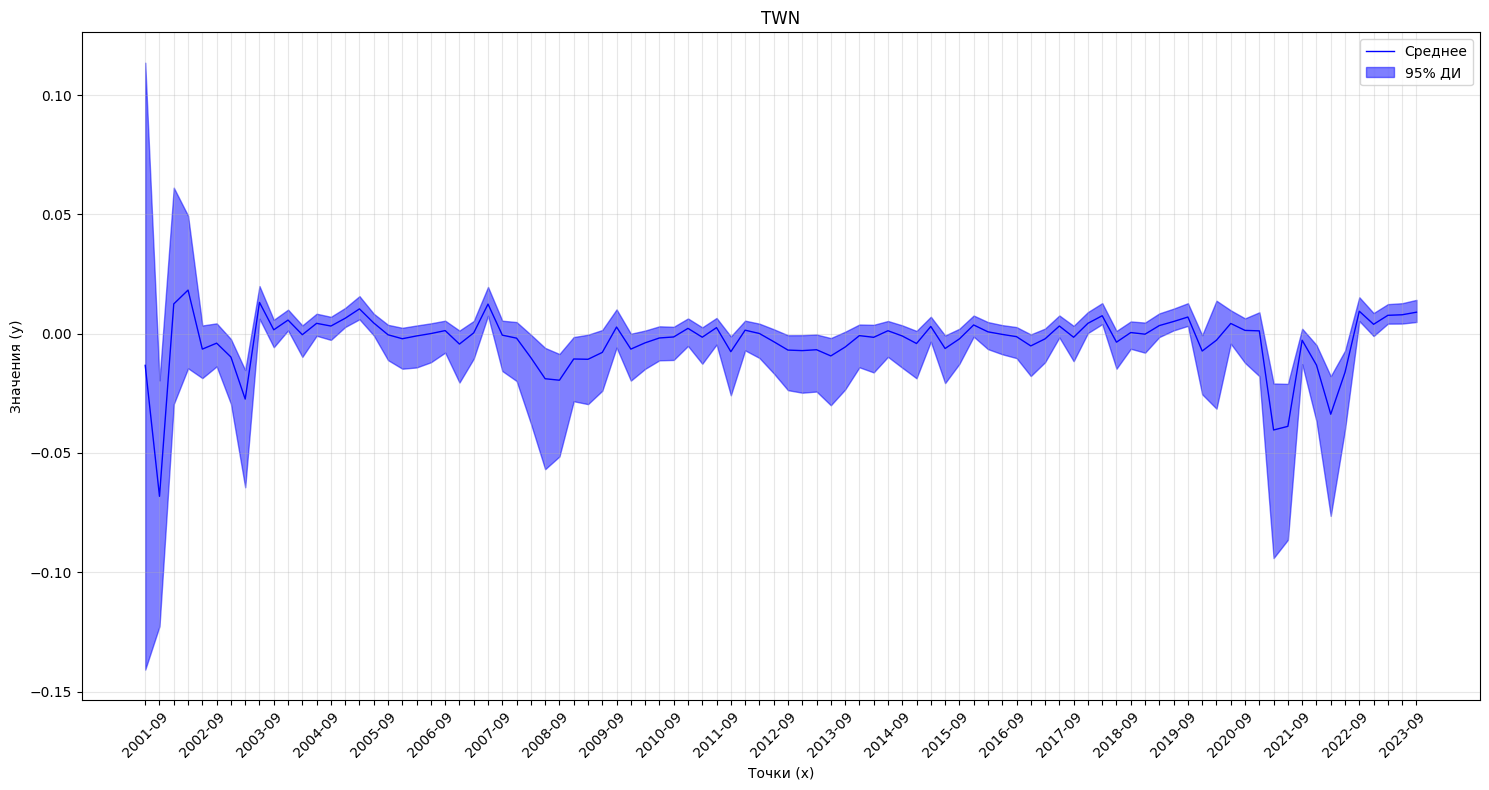

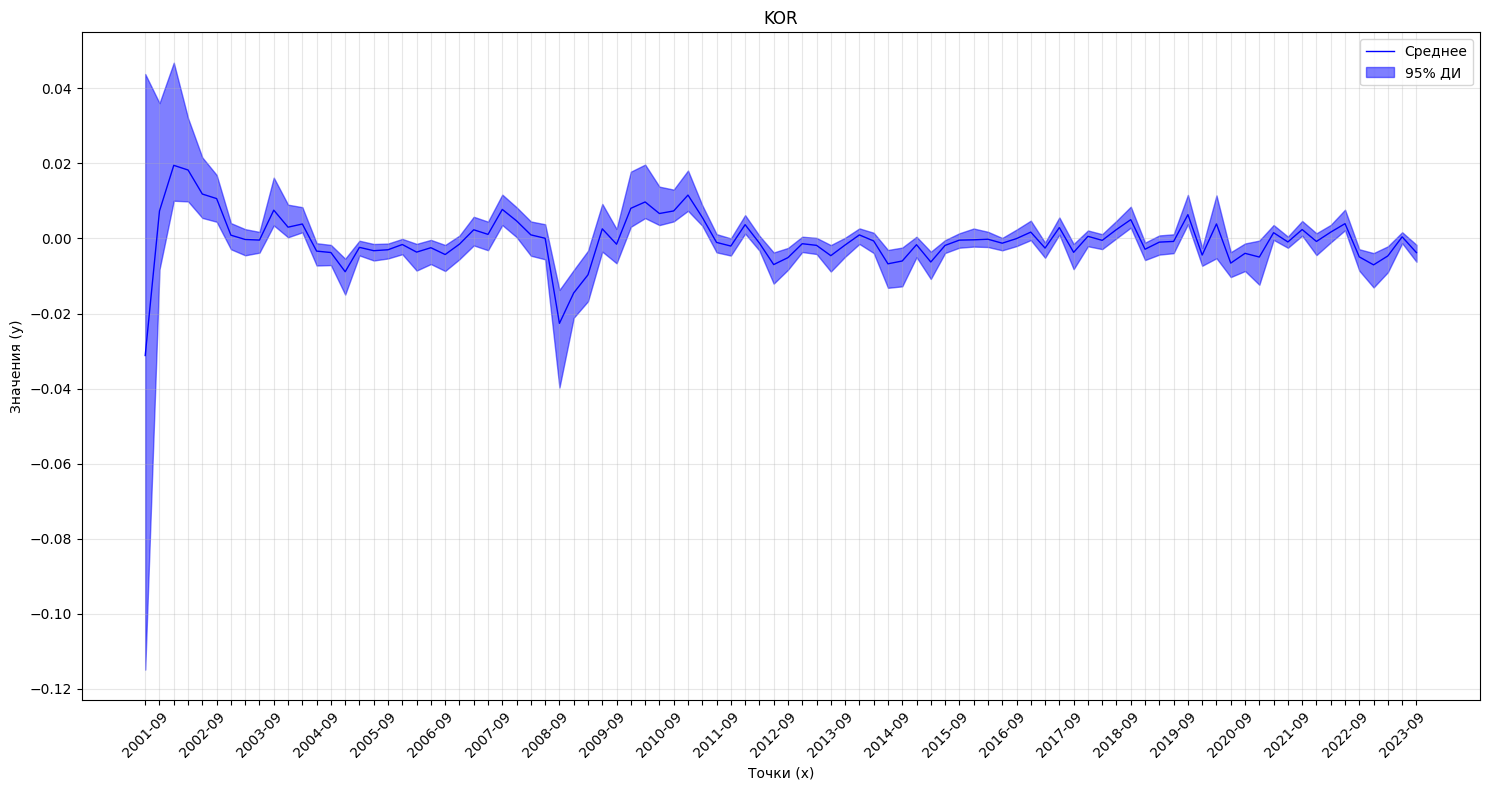

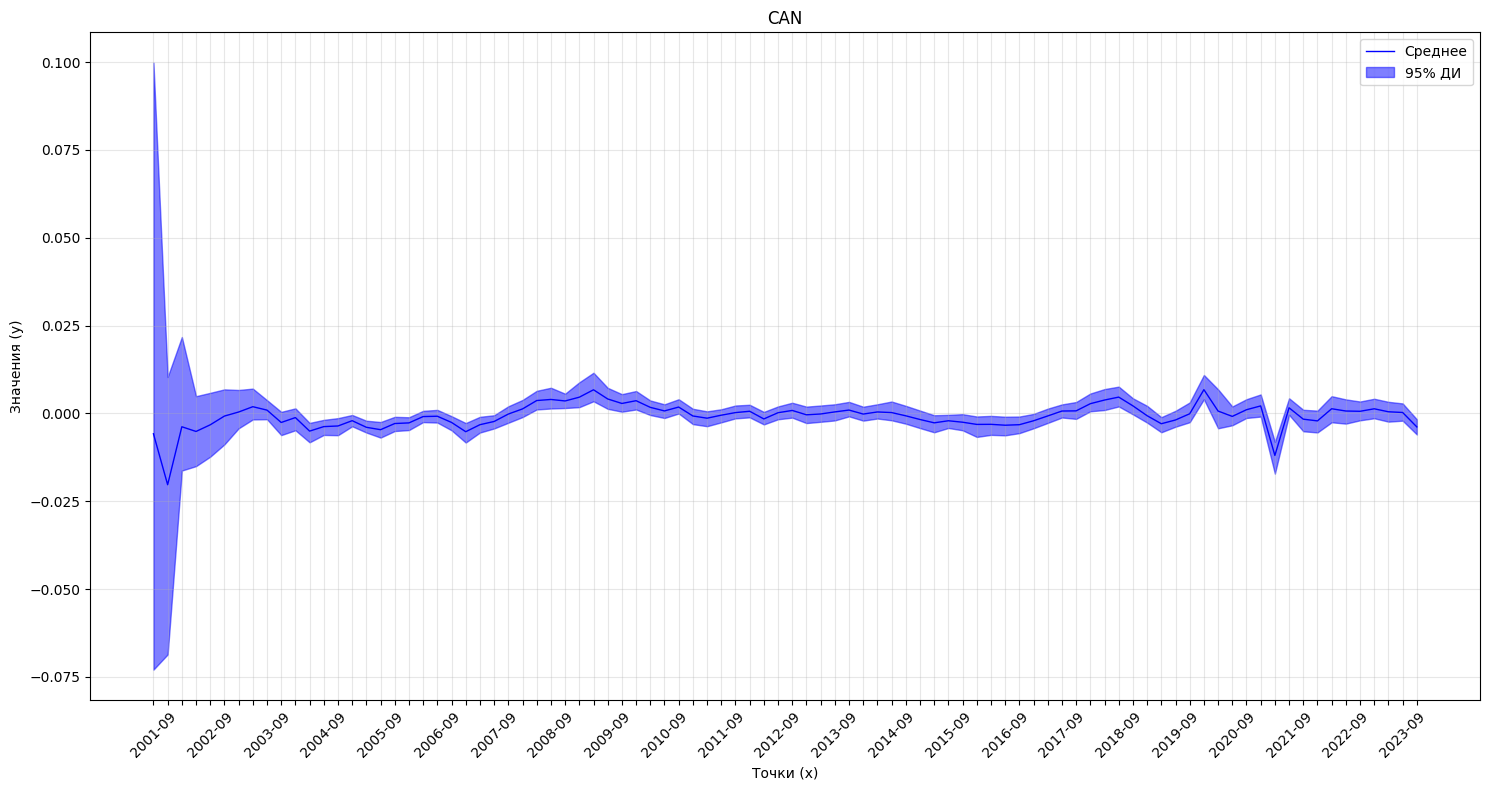

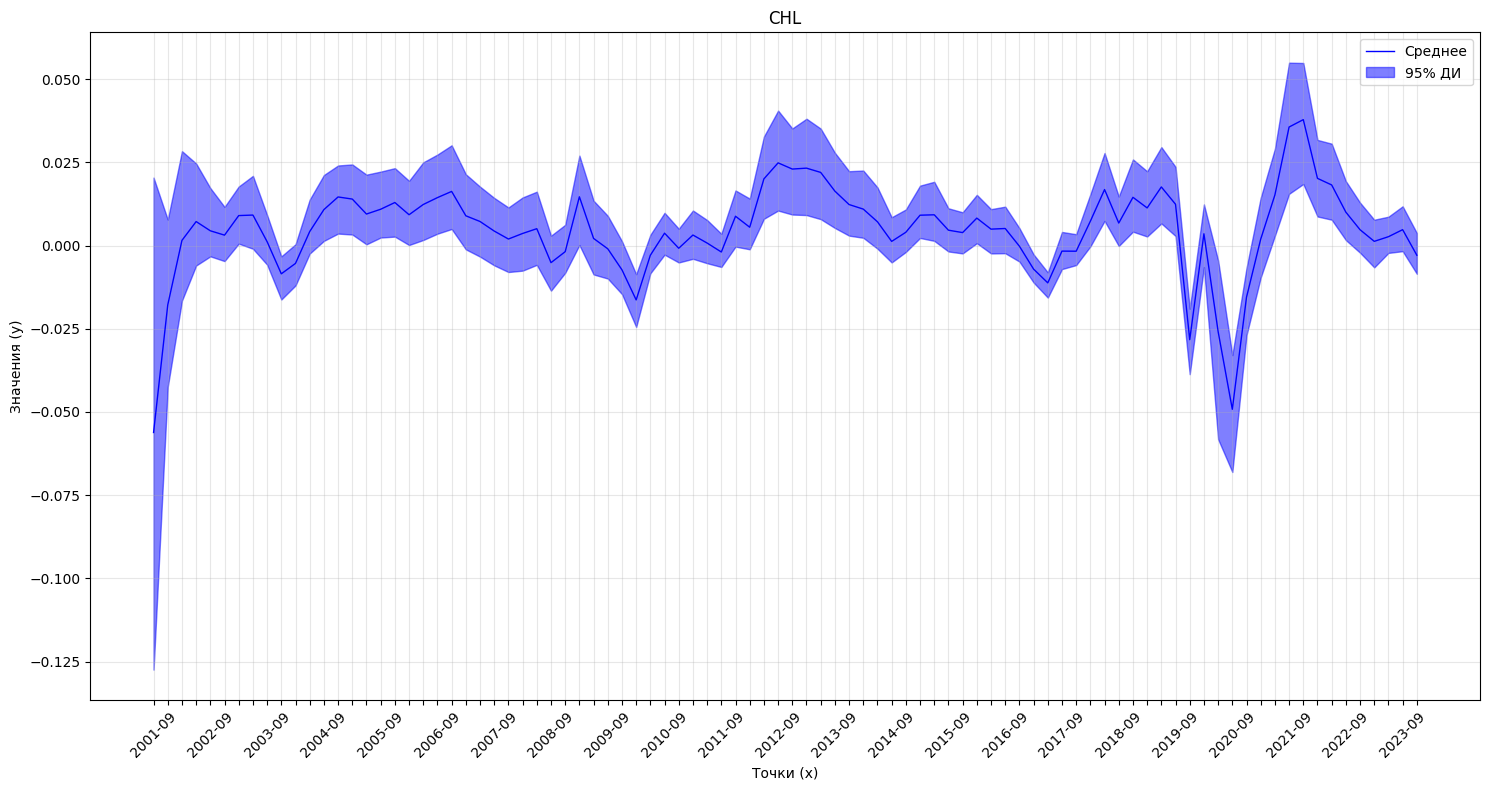

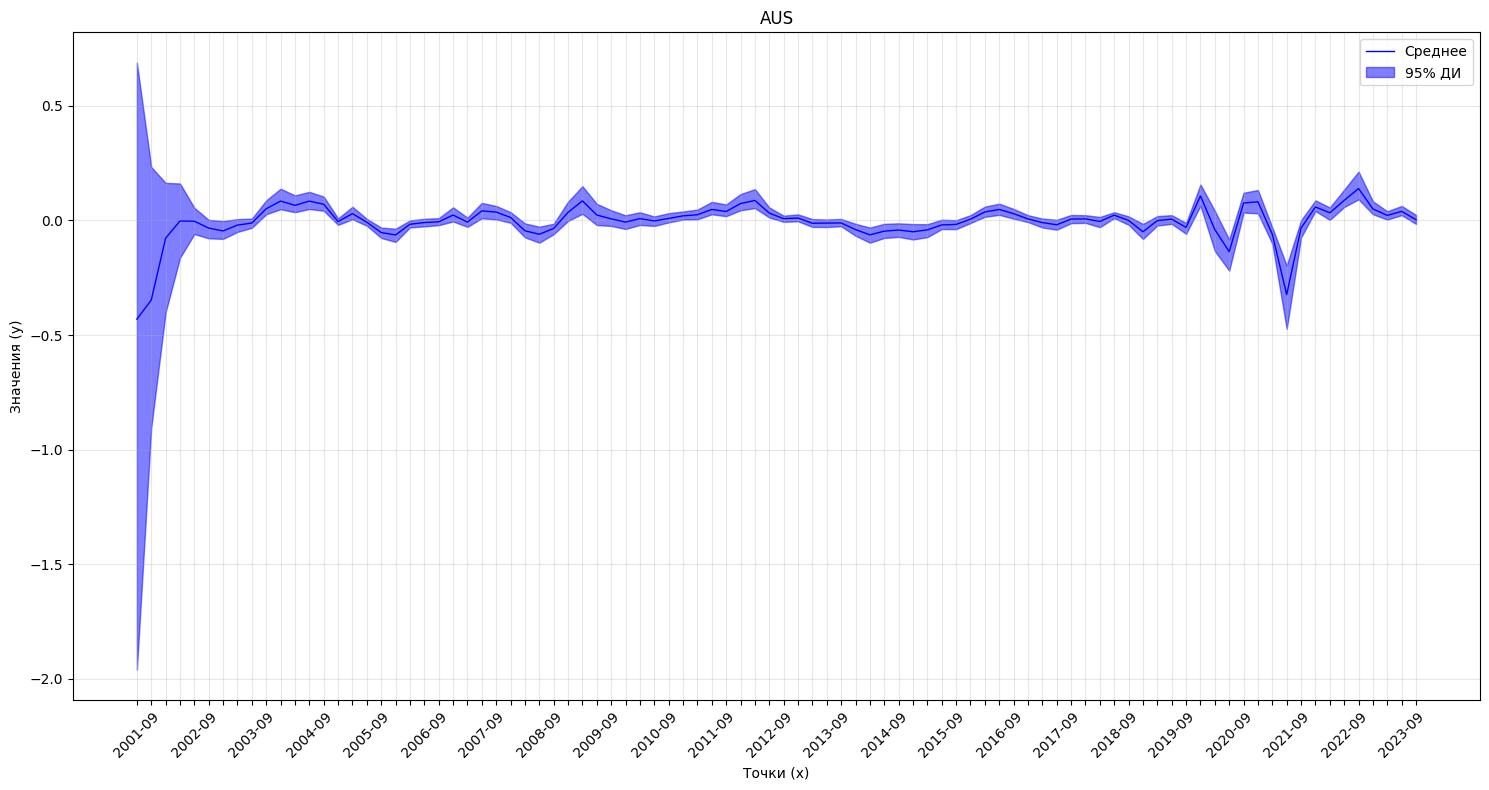

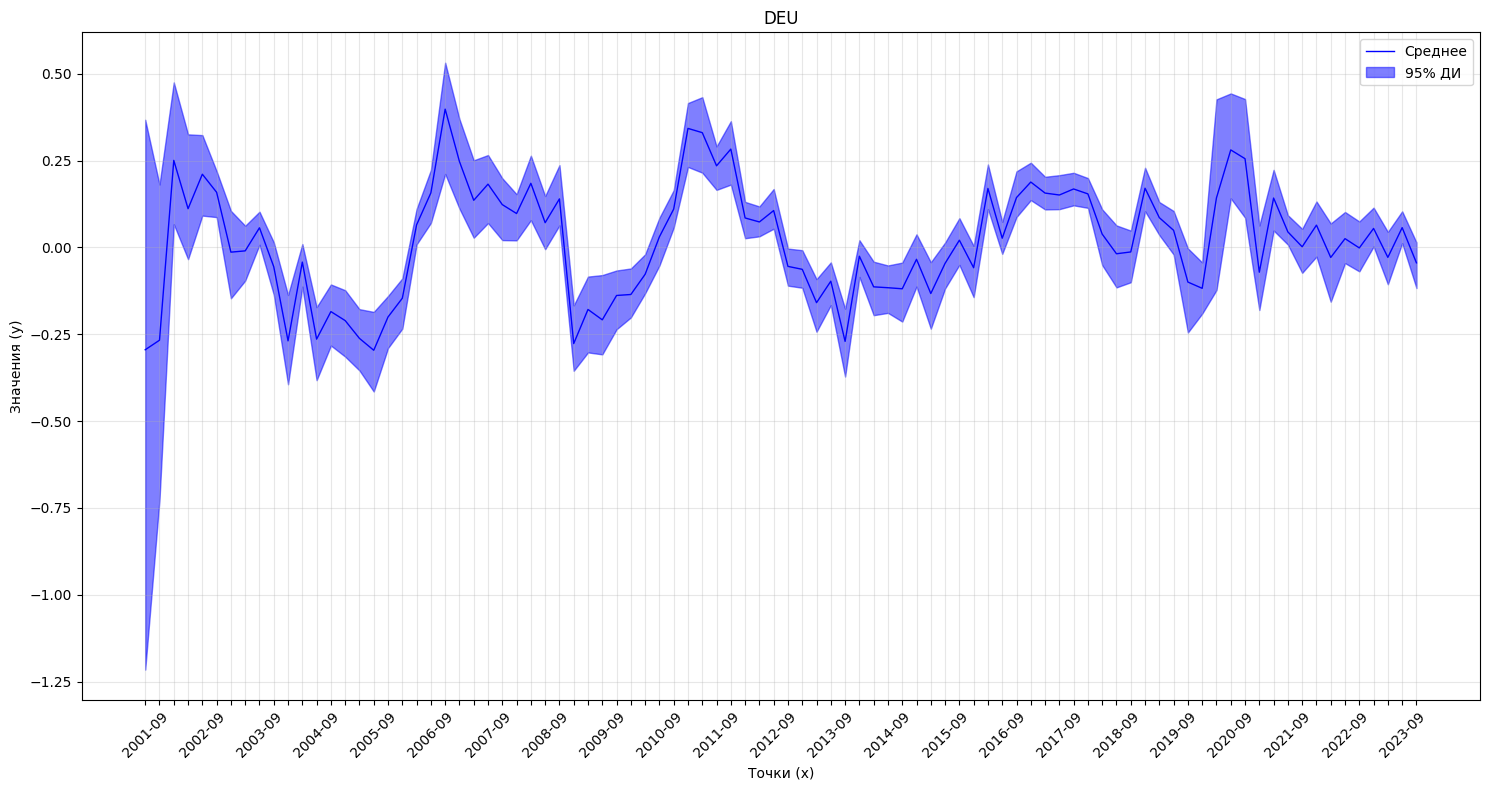

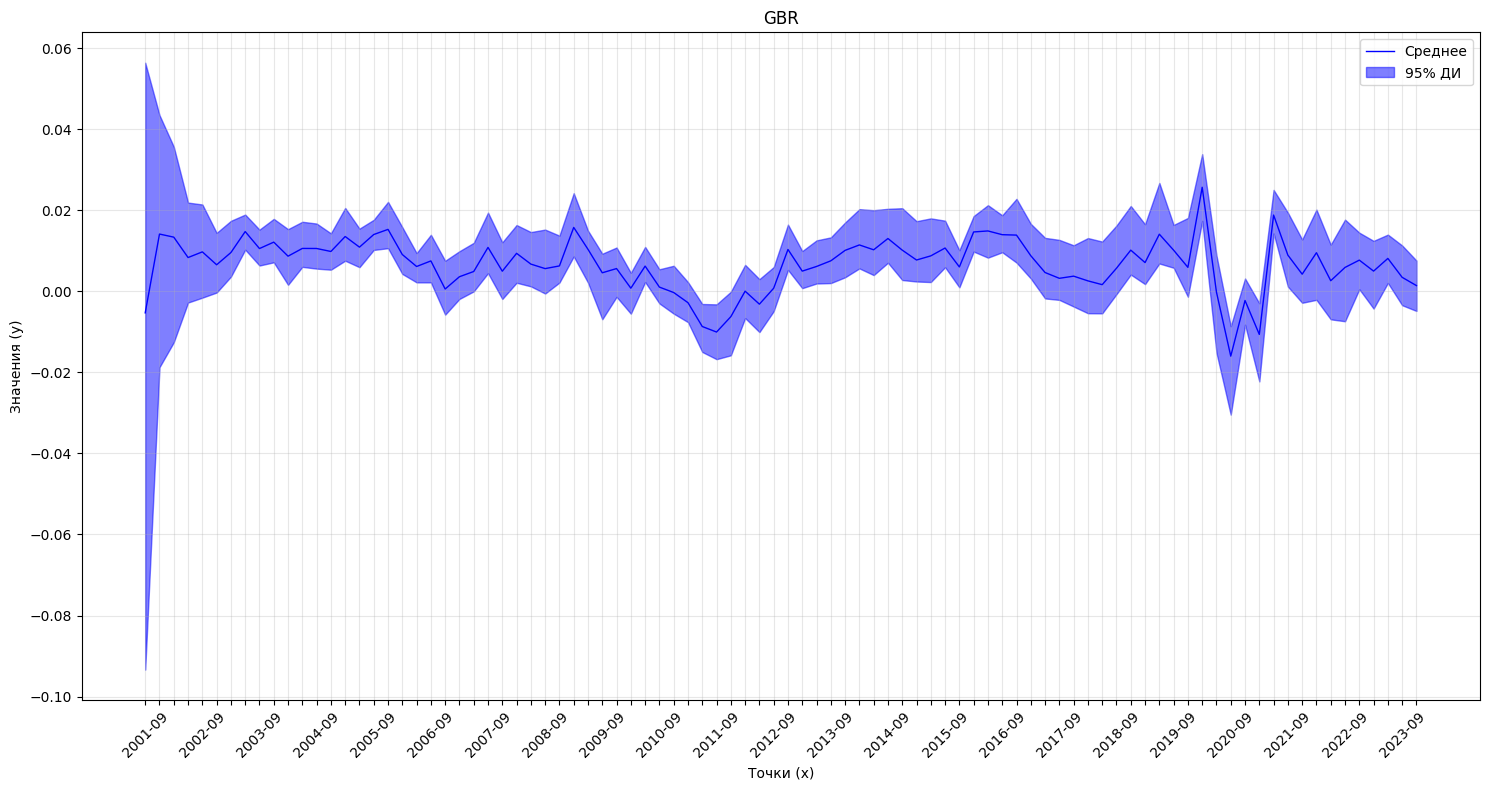

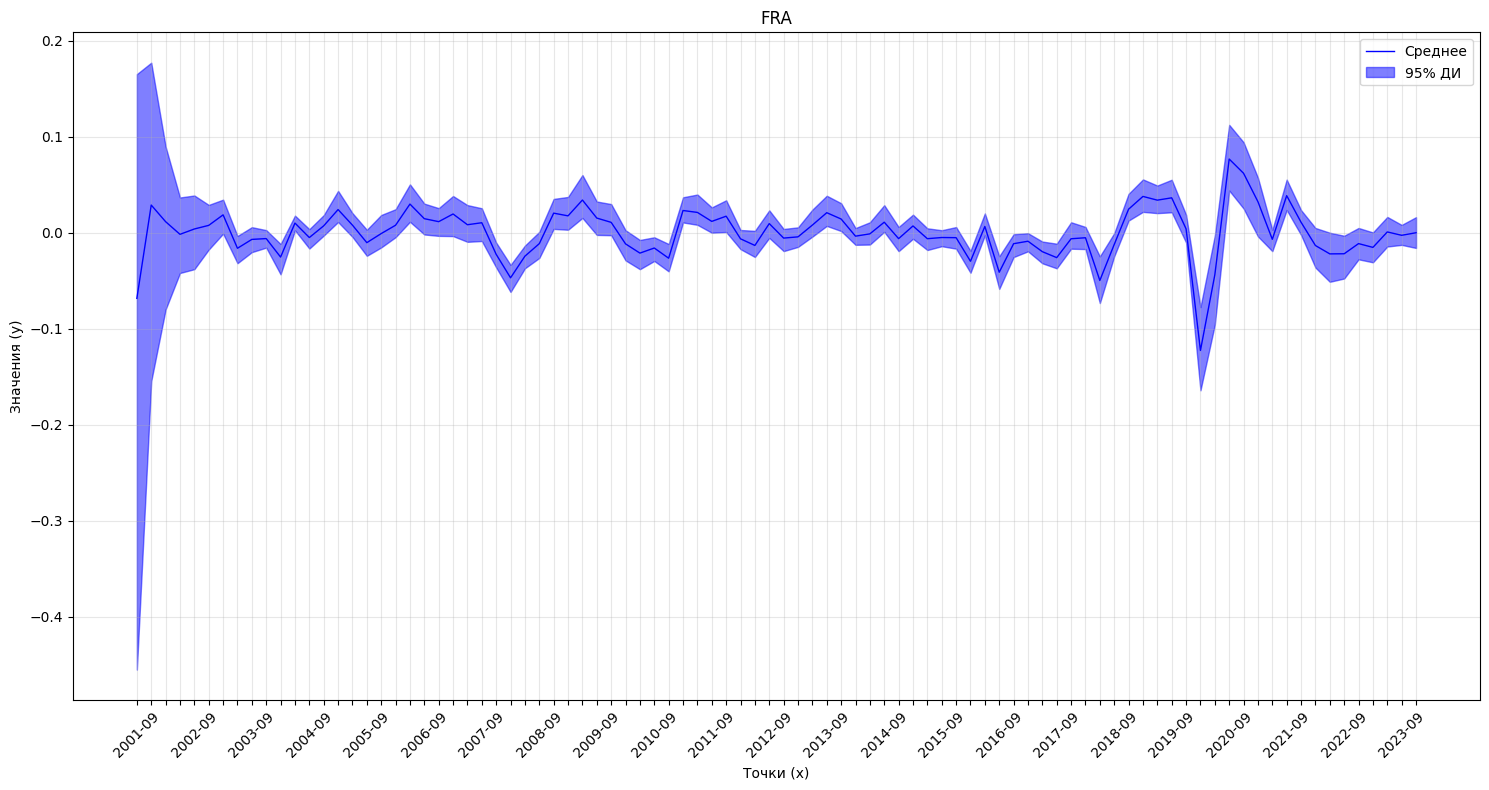

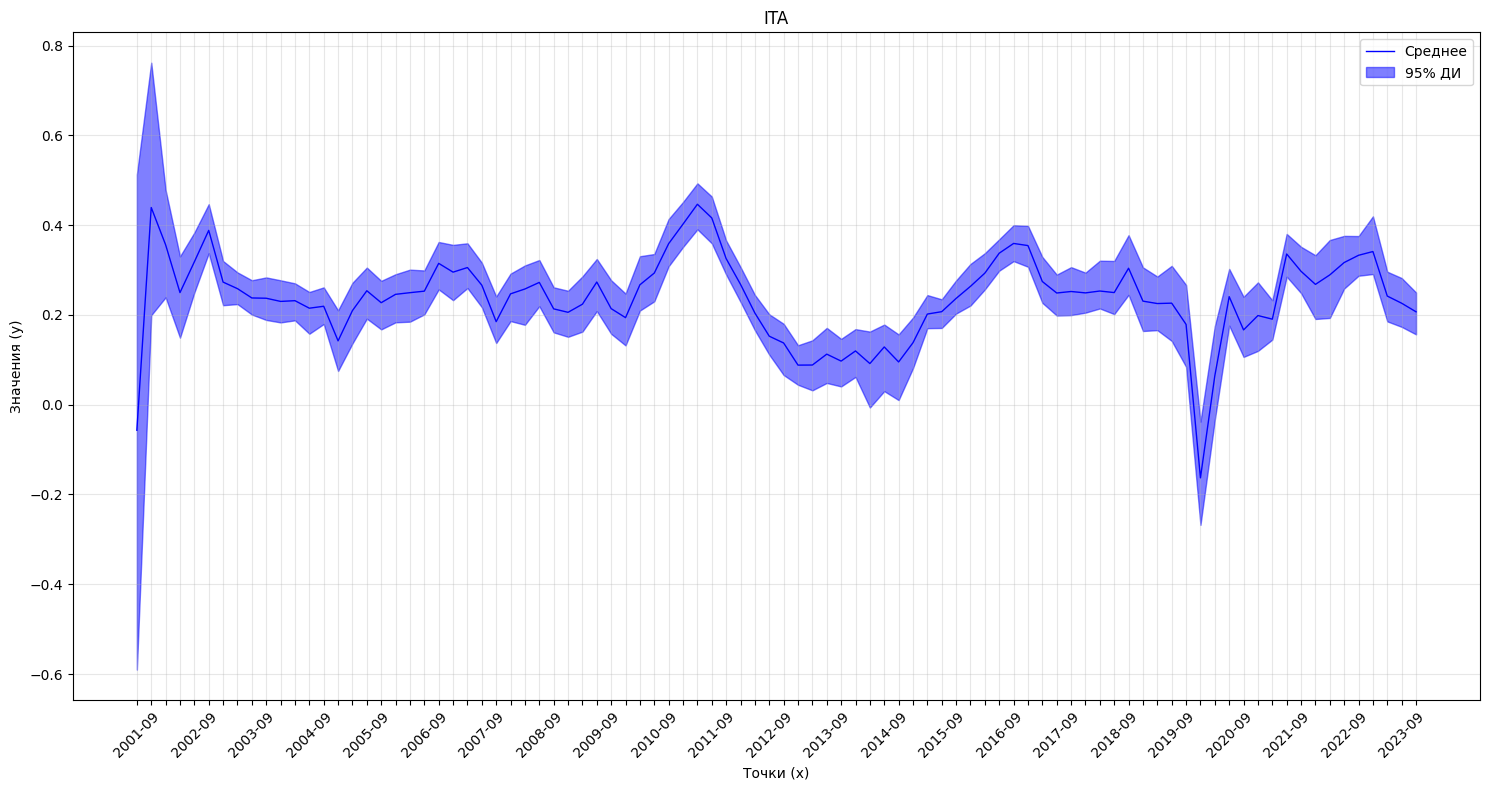

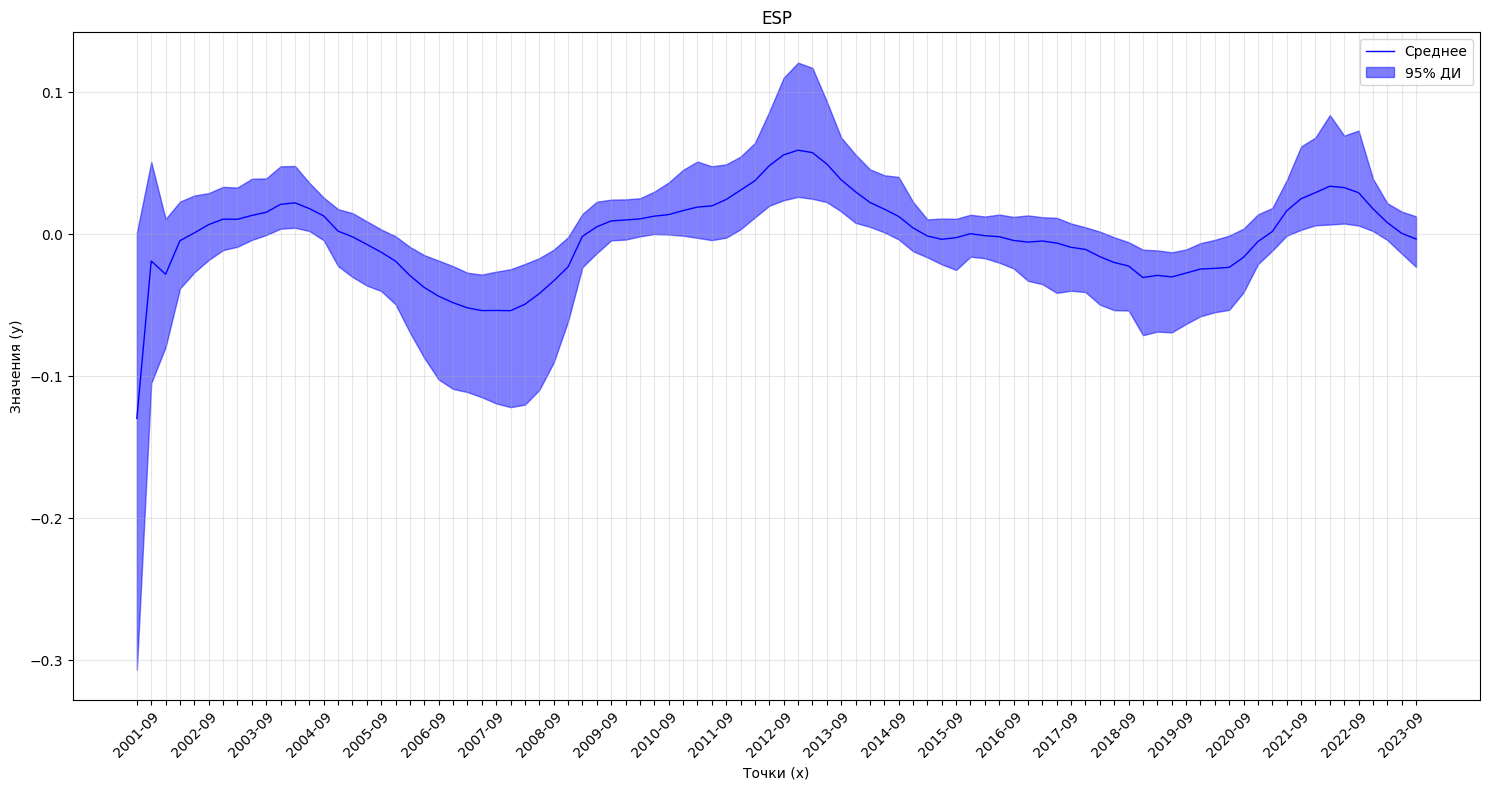

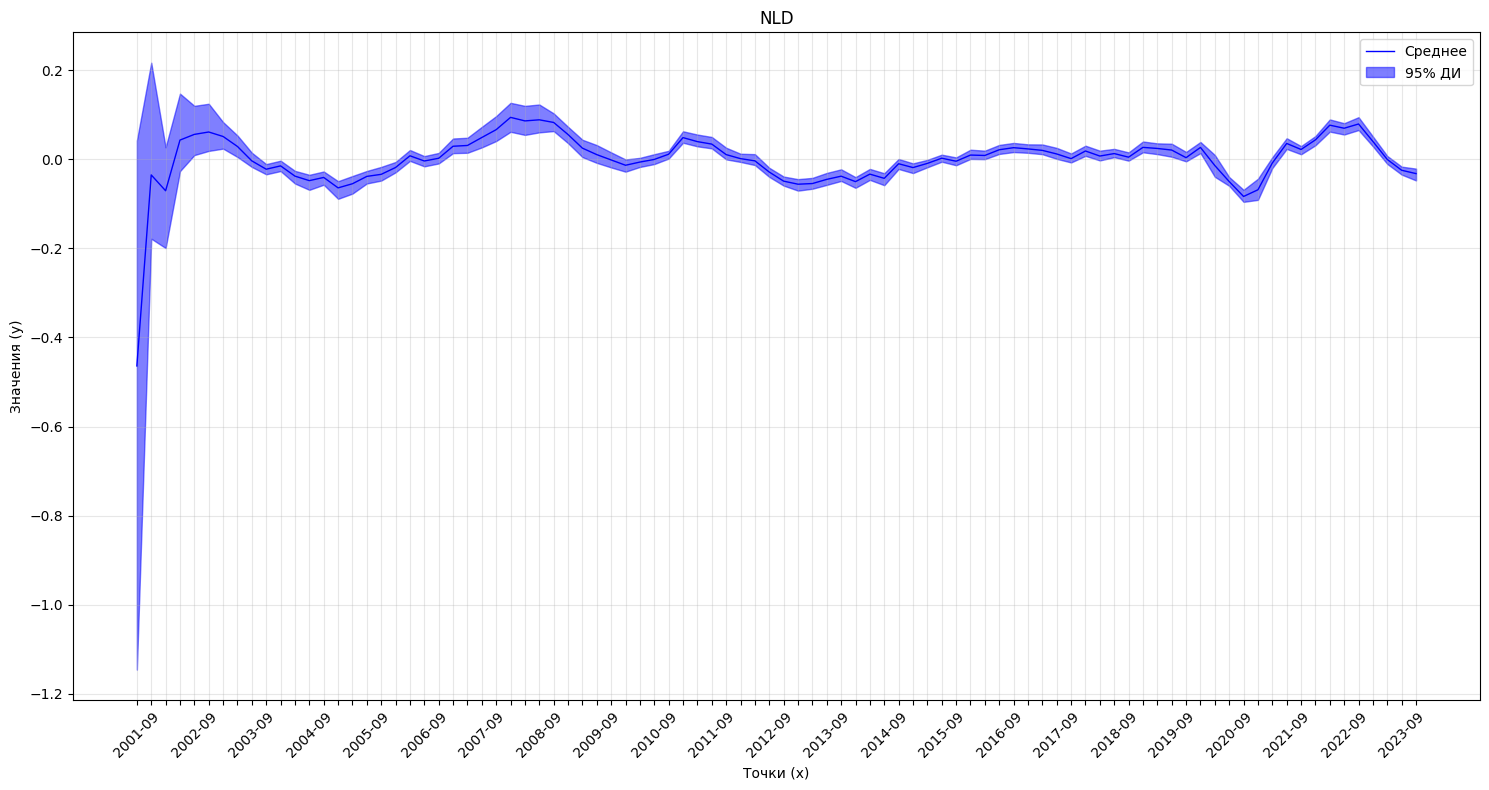

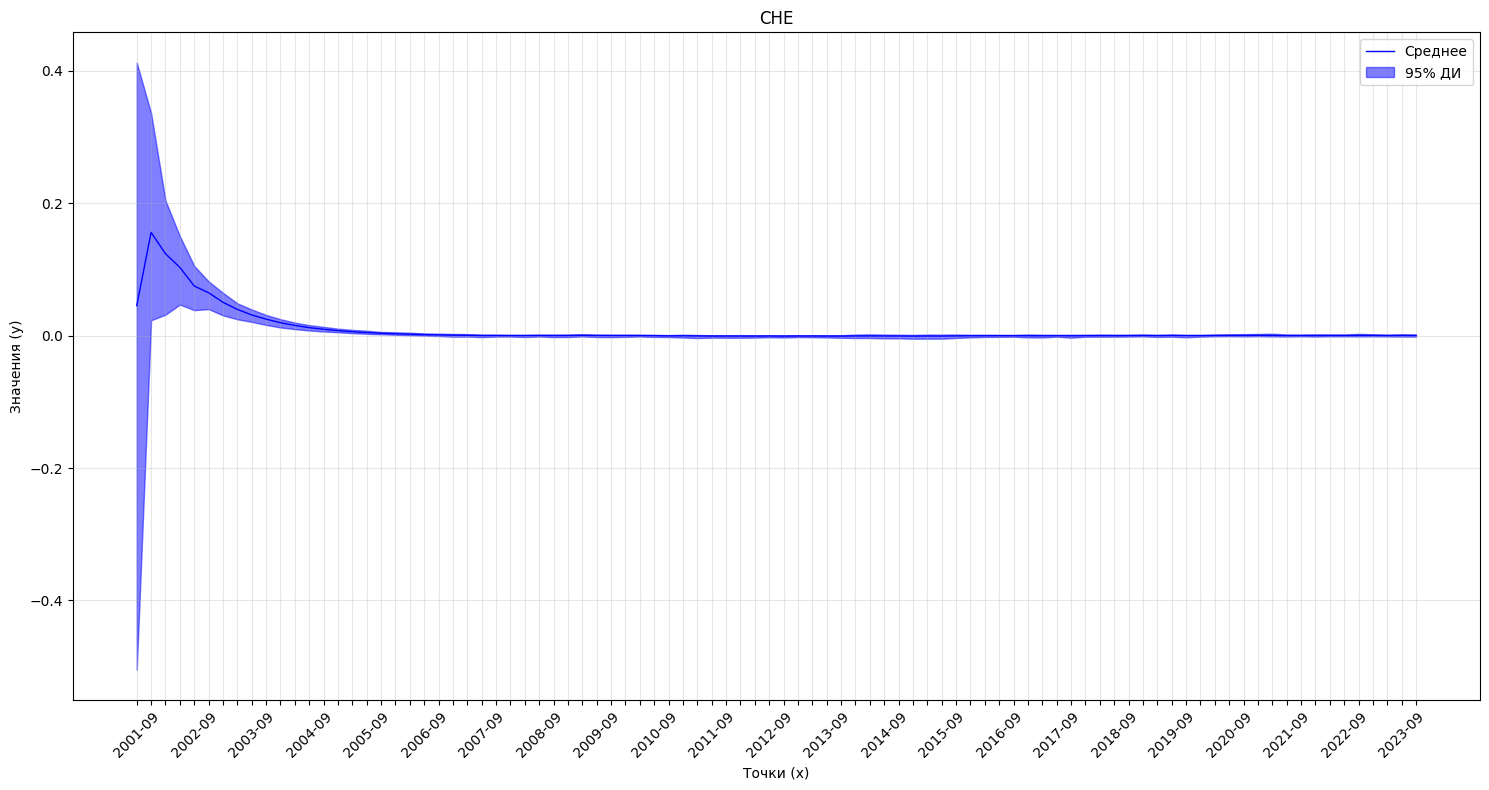

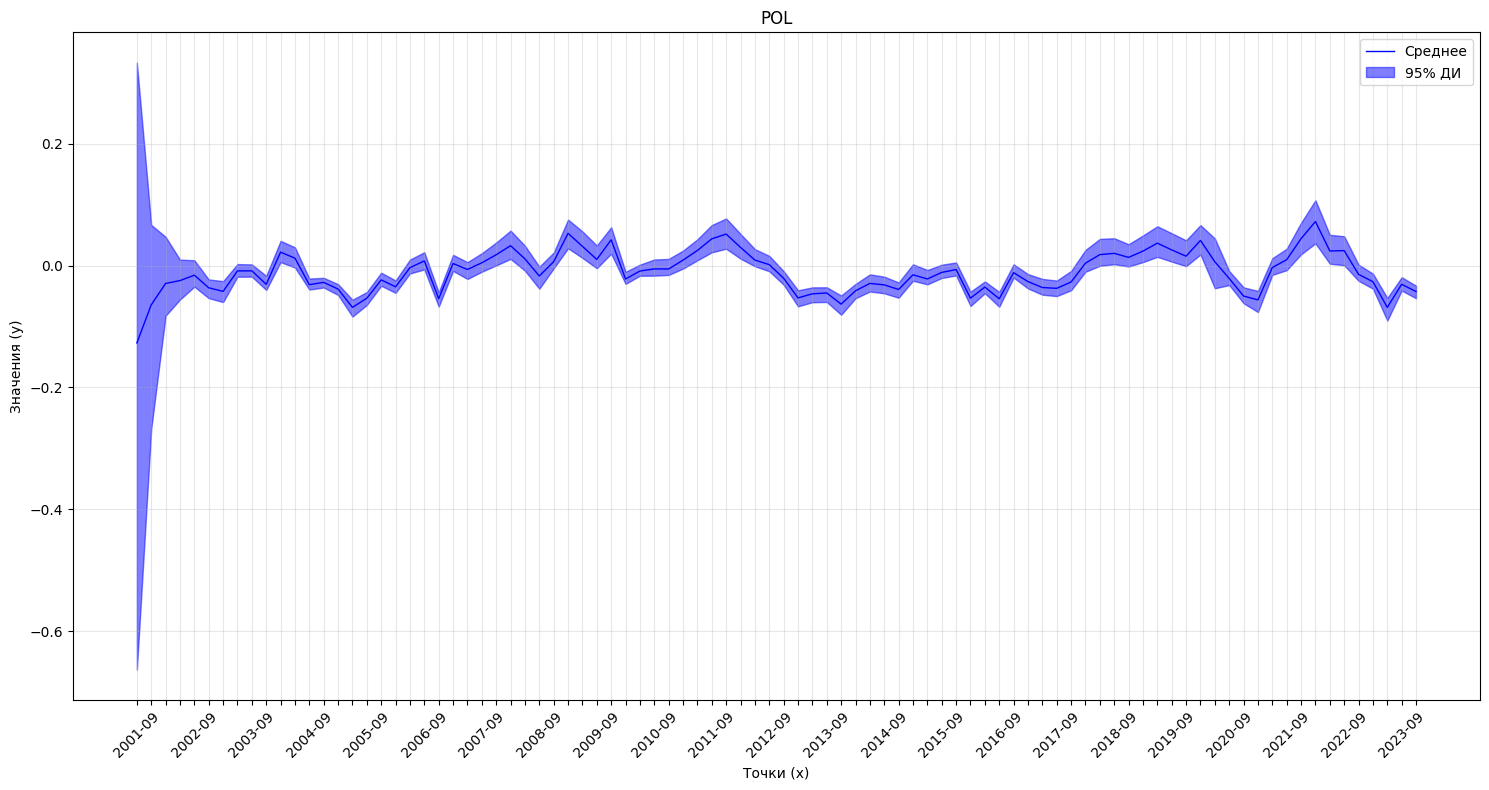

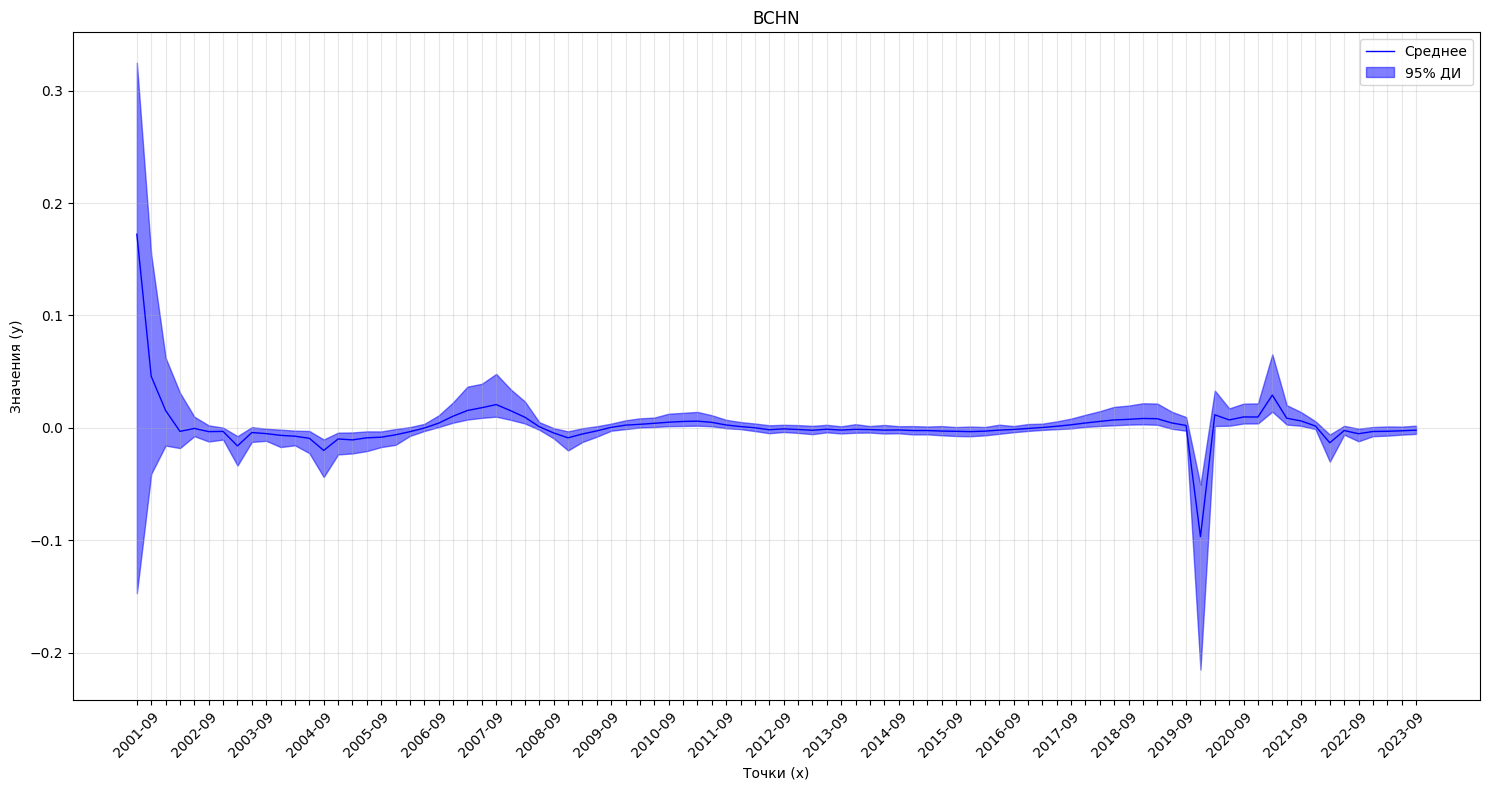

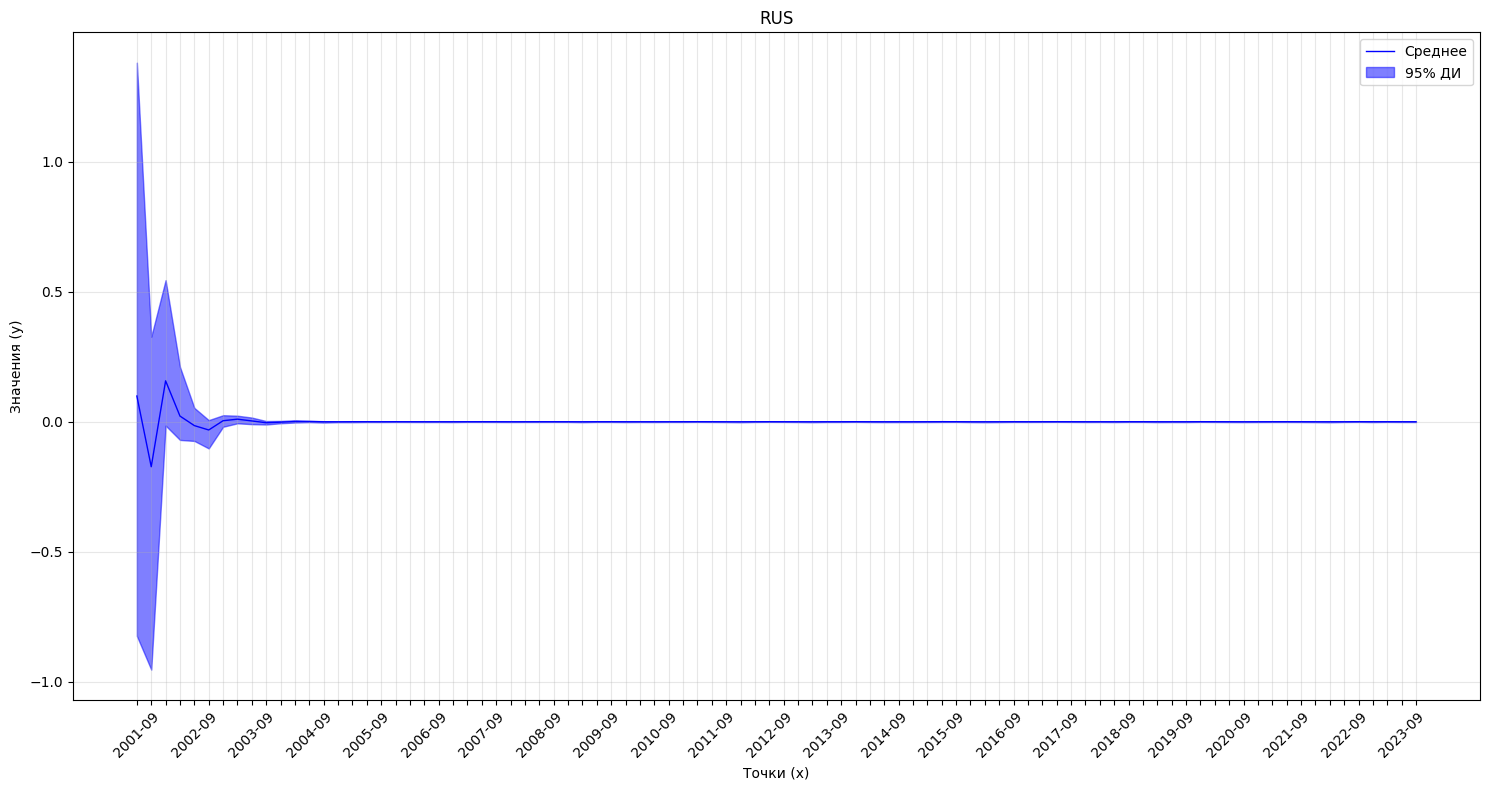

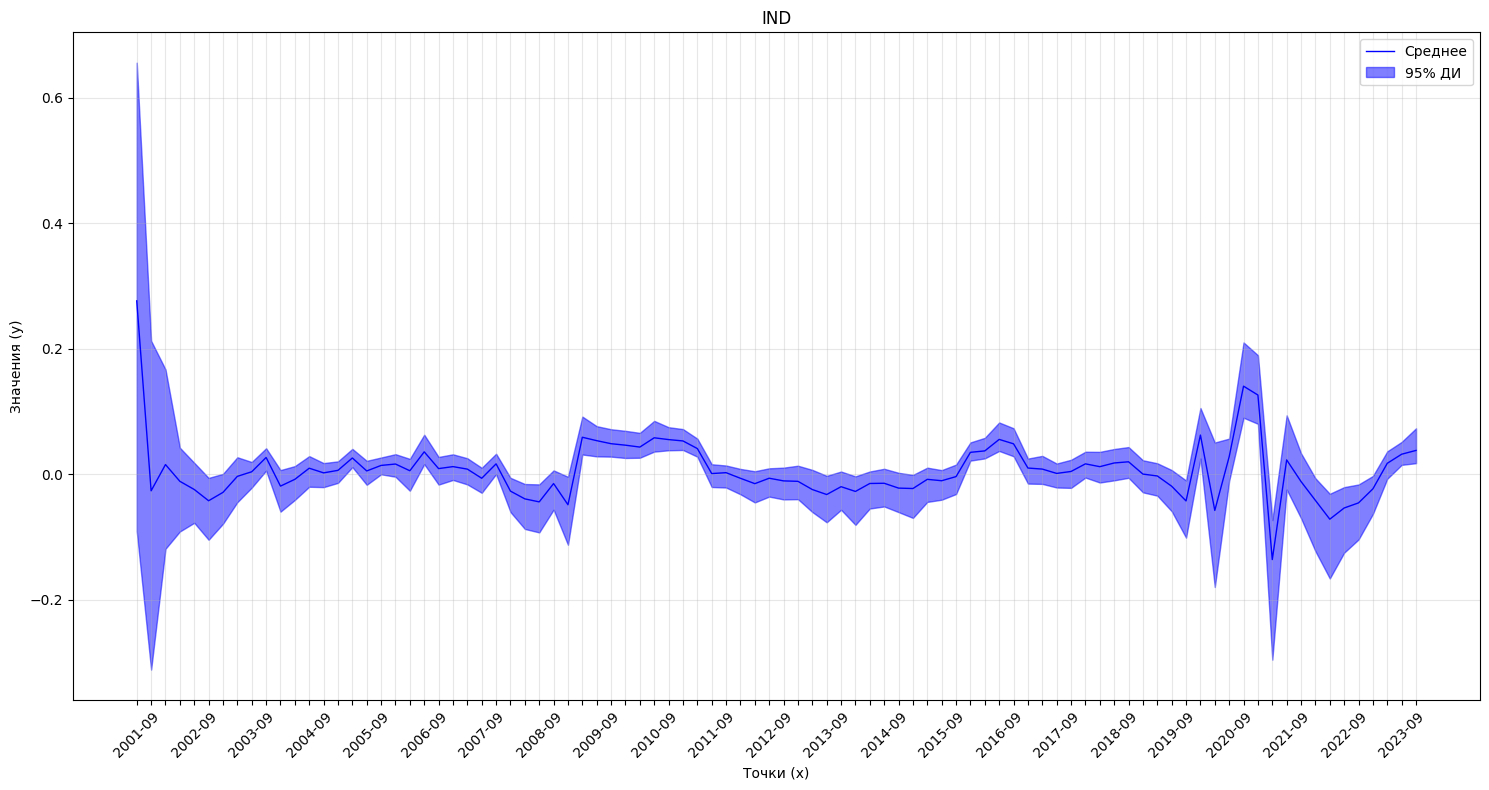

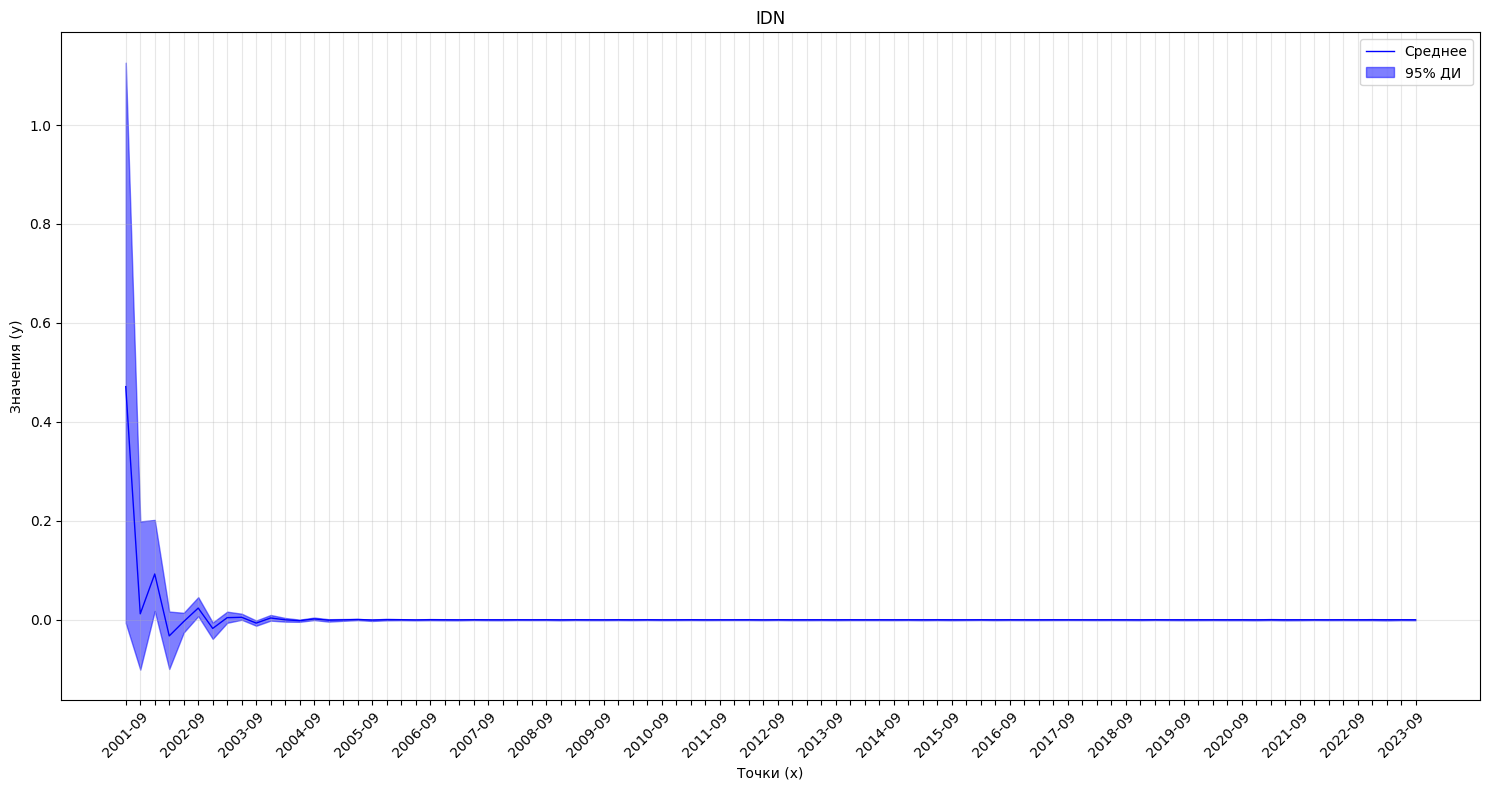

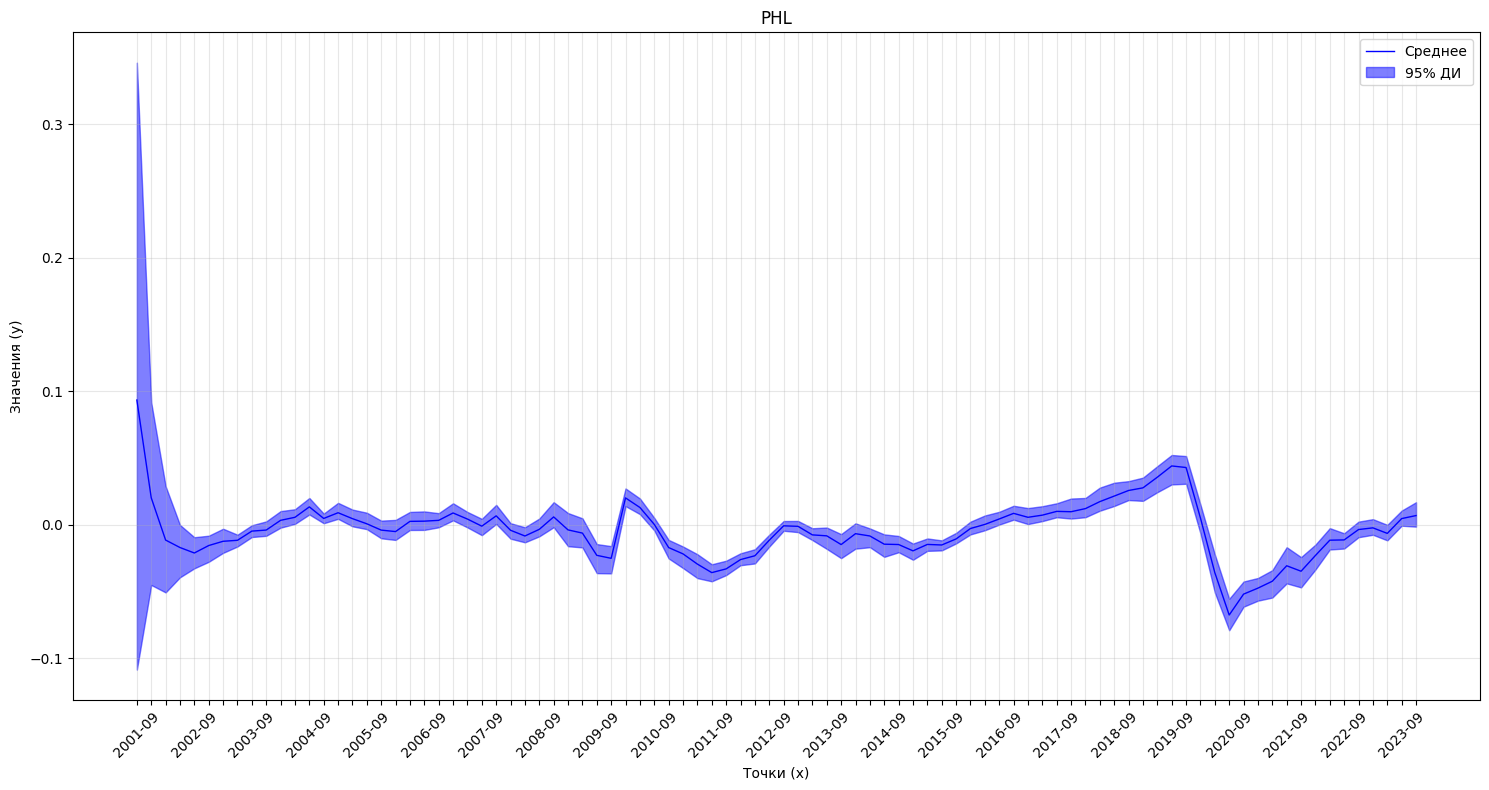

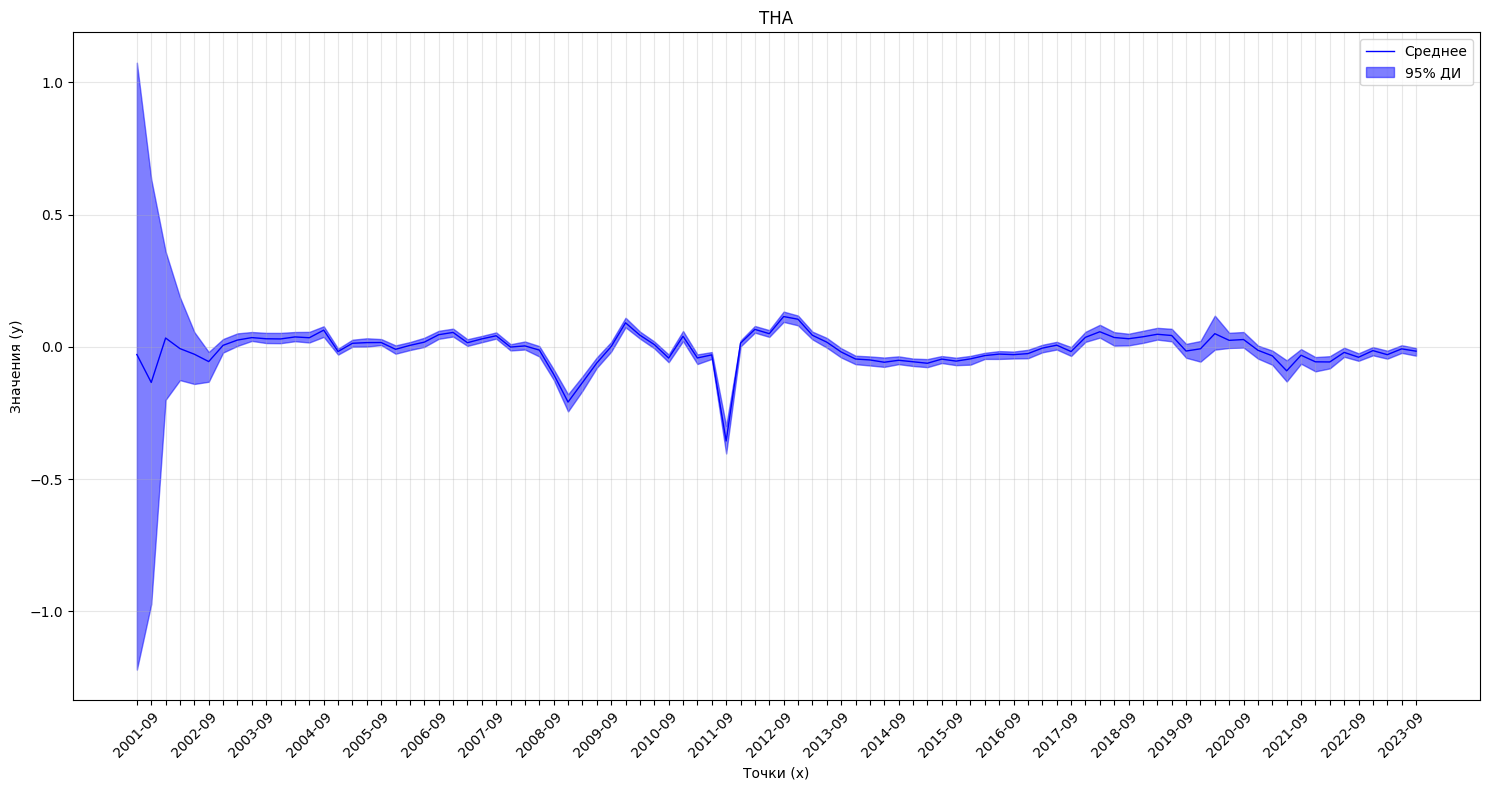

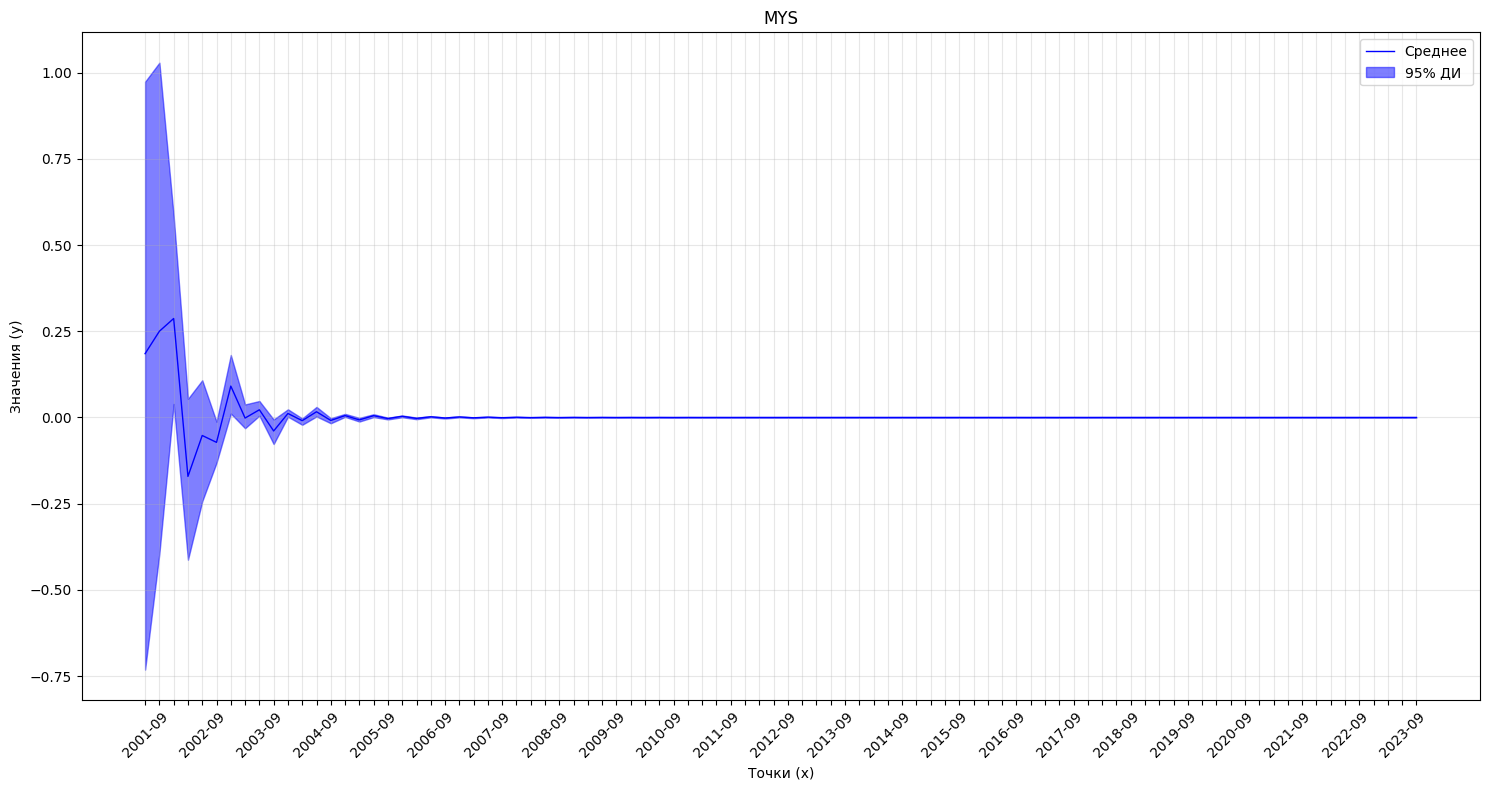

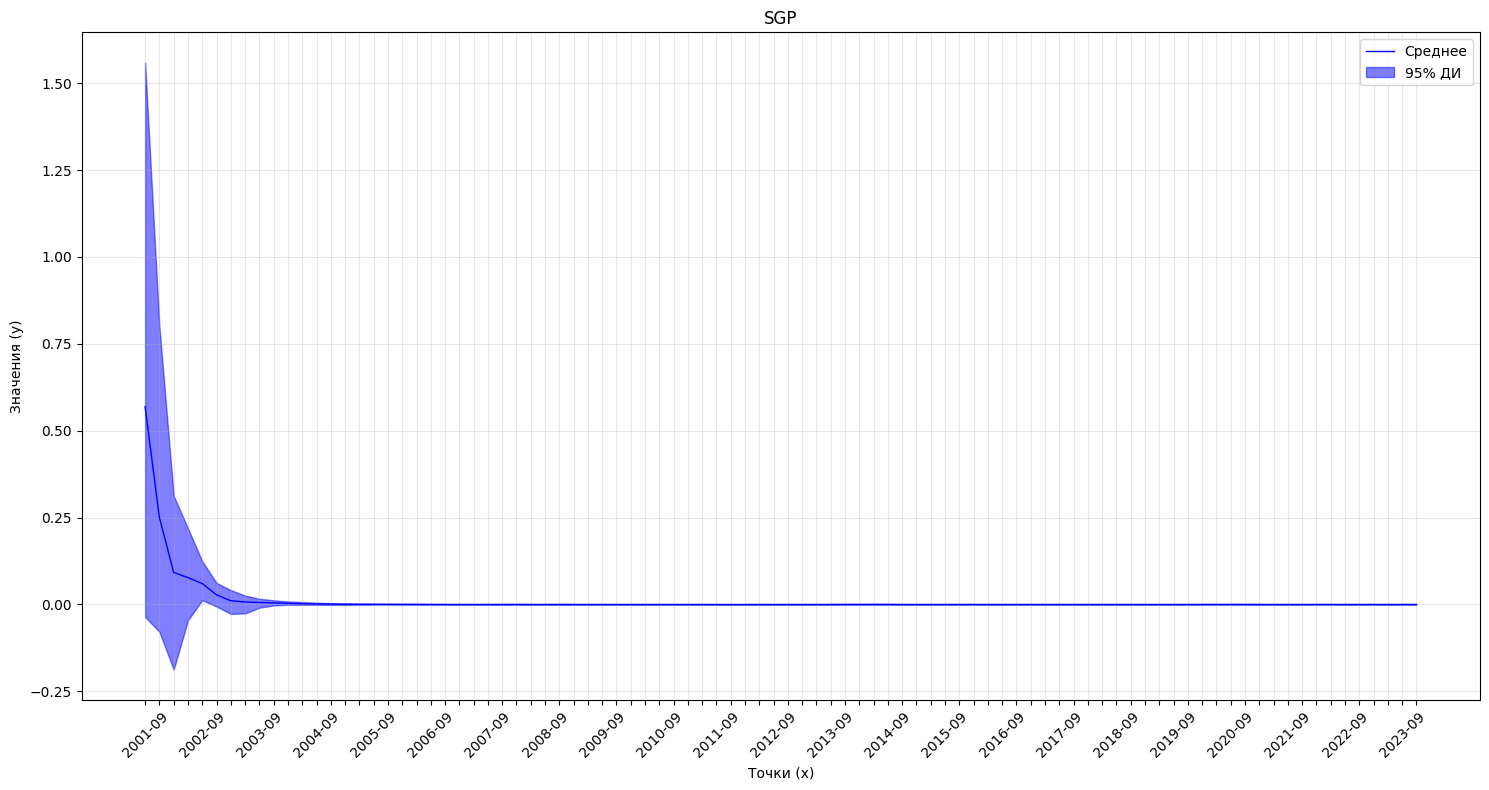

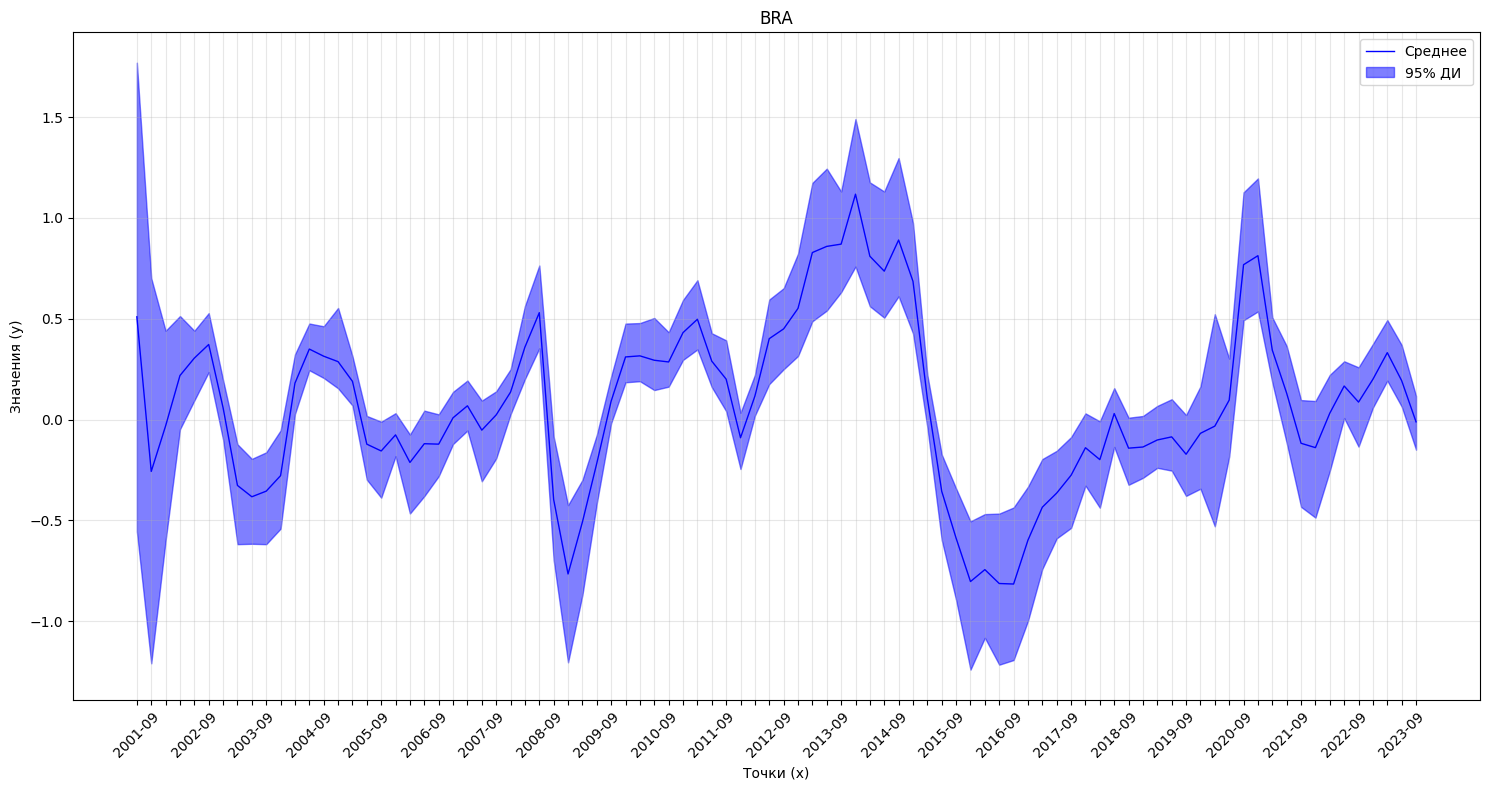

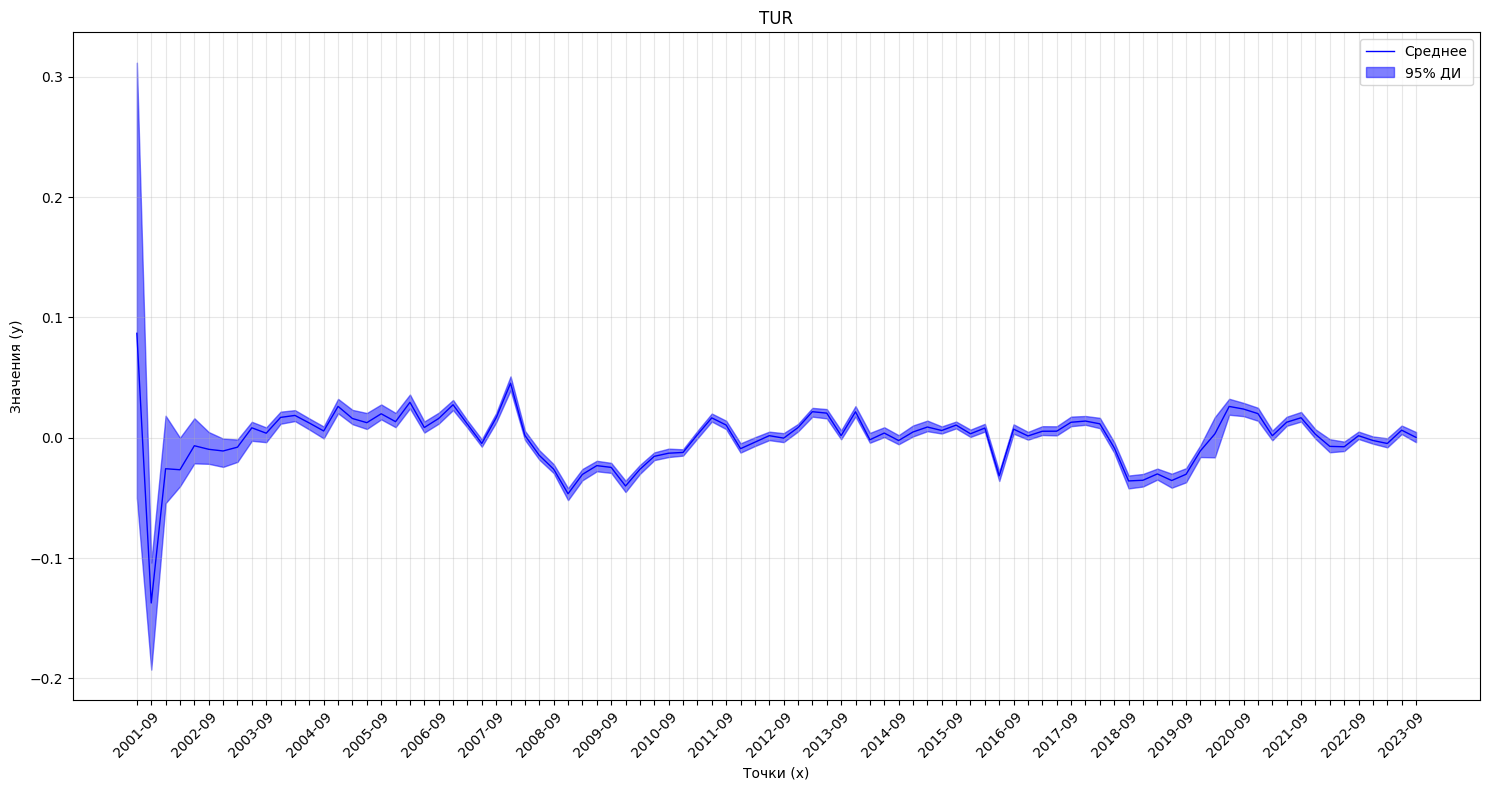

In [ ]:
# развивающиееся
for i in range(25):
  data = trace.posterior.f_country.values[1][:,[i],:]

  mean_values = data.mean(axis=0).squeeze()  # Среднее значение по первому измерению
  lower_quantile = np.quantile(data, q=0.025, axis=0).squeeze()  # Нижний квантиль
  upper_quantile = np.quantile(data, q=0.975, axis=0).squeeze()  # Верхний квантиль

  # Готовим x-значения (предполагаем, что df['date'] уже определен)
  x = df['date'].dt.strftime('%Y-%m').unique().tolist()

  # Отображаем только каждую 4-ю метку на оси X
  x_ticks = [x[i] if i % 4 == 0 else '' for i in range(len(x))]

  # Строим график
  plt.figure(figsize=(15, 8))
  plt.plot(x, mean_values, label="Среднее", color="blue", linewidth=1)

  # Закрашиваем доверительный интервал
  plt.fill_between(x, lower_quantile, upper_quantile, color="blue", alpha=0.5, label="95% ДИ")

  # Настройка осей
  plt.xticks(ticks=range(len(x)), labels=x_ticks, rotation=45)  # Выводим только каждую 4-ю метку
  plt.title(list(countries_value.keys())[i])
  plt.xlabel("Точки (x)")
  plt.ylabel("Значения (y)")
  plt.legend()
  plt.grid(alpha=0.3)

  # Отображаем график
  plt.tight_layout()  # Автоматическая подгонка элементов графика
  plt.show()

In [ ]:
trace.posterior.alpha_tanh.values.shape

(3, 5000, 1, 90)

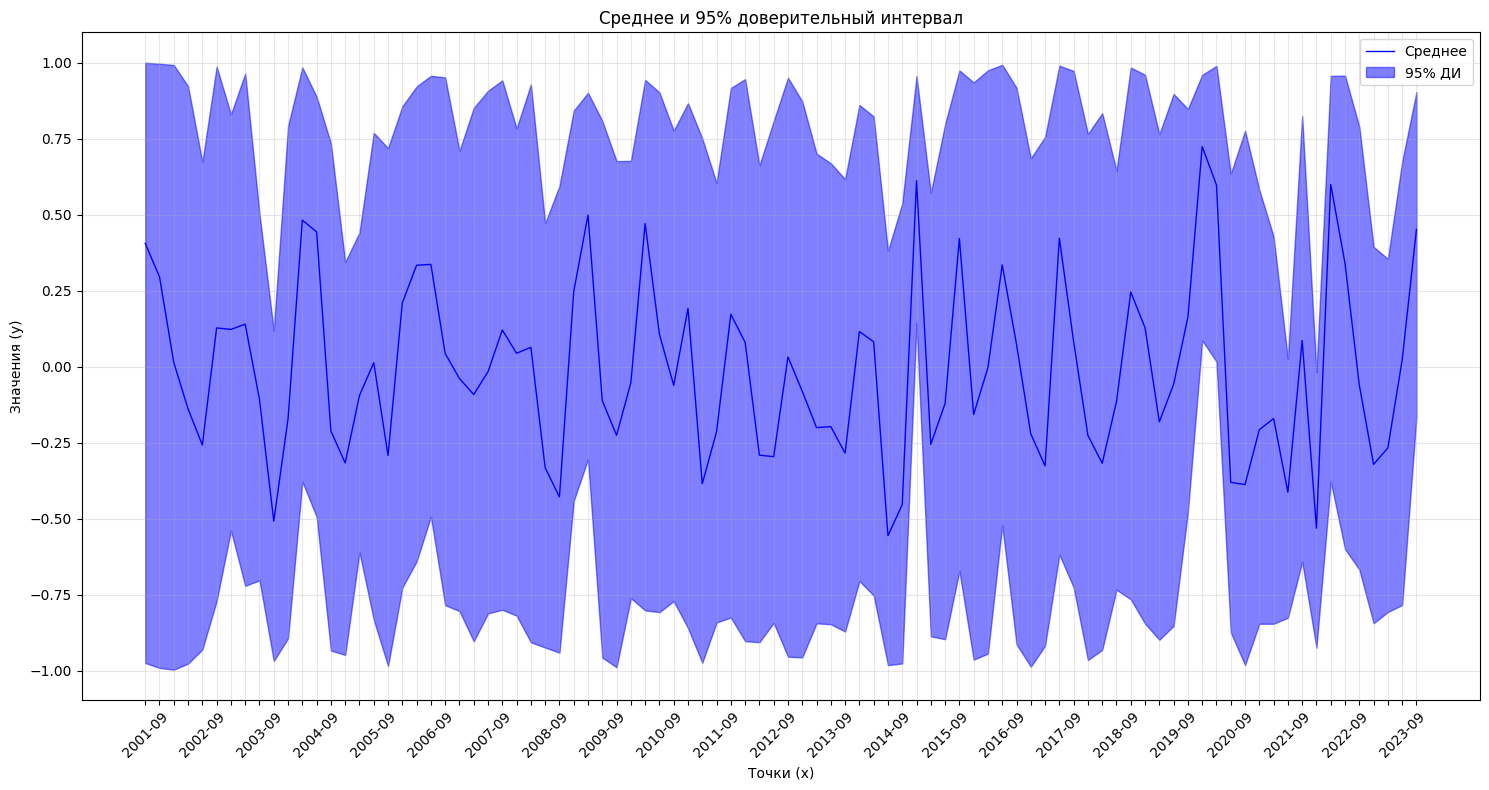

In [ ]:
# развивающиееся

data = trace.posterior.alpha_tanh.values[2][:,[0],:]

mean_values = data.mean(axis=0).squeeze()  # Среднее значение по первому измерению
lower_quantile = np.quantile(data, q=0.025, axis=0).squeeze()  # Нижний квантиль
upper_quantile = np.quantile(data, q=0.975, axis=0).squeeze()  # Верхний квантиль

# Готовим x-значения (предполагаем, что df['date'] уже определен)
x = df['date'].dt.strftime('%Y-%m').unique().tolist()

# Отображаем только каждую 4-ю метку на оси X
x_ticks = [x[i] if i % 4 == 0 else '' for i in range(len(x))]

# Строим график
plt.figure(figsize=(15, 8))
plt.plot(x, mean_values, label="Среднее", color="blue", linewidth=1)

# Закрашиваем доверительный интервал
plt.fill_between(x, lower_quantile, upper_quantile, color="blue", alpha=0.5, label="95% ДИ")

# Настройка осей
plt.xticks(ticks=range(len(x)), labels=x_ticks, rotation=45)  # Выводим только каждую 4-ю метку
plt.title("Среднее и 95% доверительный интервал")
plt.xlabel("Точки (x)")
plt.ylabel("Значения (y)")
plt.legend()
plt.grid(alpha=0.3)

# Отображаем график
plt.tight_layout()  # Автоматическая подгонка элементов графика
plt.show()